### Use a SOM to construct feature likelihood

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import abc
import time

from astropy.table import Table

In [3]:
class MapGeometry(abc.ABC):
    
    def __init__(self, size):
        self._size = size
        self._separations = None
    
    @property
    def size(self):
        """The flattened size of this map.
        """
        return self._size
    
    @property
    def separations(self):
        """The matrix of pairwise separations between map nodes.
        
        Uses lazy evaluation.  The matrix might be sparse.
        """
        if self._separations is None:
            self._separations = self._calculate_separations()
        return self._separations
    
    @abc.abstractmethod
    def _calculate_separations(self):
        raise NotImplementedError()
        
    @abc.abstractmethod
    def plot(self, values, ax=None, **kwargs):
        """Plot a representation of the specified values for this map.
        
        Parameters
        ----------
        values : array
            1D array of length :attr:`size`    
        ax : matplotlib axis or None
            Plot axis to use, or create a default axis when None.
        kwargs : dict
            Additional plot keyword arguments to pass to the implementation.
        """
        raise NotImplementedError()

In [4]:
class Grid(MapGeometry):
    
    def __init__(self, *signature, metric='L2'):
        """Create a rectilinear grid map geometry.
        
        The grid shape is specified by the absolute values of the signature.        
        A negative value in the signature indicates that distances along the
        corresponding axis are calculated using wrap around.
        """
        
        print([abs(k) for k in signature])
        
        shape = [abs(k) for k in signature]
        x = np.empty(shape=shape)
        super(Grid, self).__init__(x.size)
        self._shape = x.shape
        self._wrap = [k < 0 for k in signature]
        if metric not in ('L0', 'L1', 'L2'):
            raise ValueError('Invalid metric "{metric}", should be one of L0, L1, L2.')
        self._metric = metric
        
    @property
    def shape(self):
        return self._shape
    
    @property
    def wrap(self):
        return self._wrap
    
    @property
    def metric(self):
        return self._metric
    
    def _calculate_separations(self):
        ndim = len(self.shape)
        separation = np.zeros(self.shape + self.shape)
        # Loop over axes.
        for k, wrapk in enumerate(self._wrap):
            nk = self.shape[k]
            xk = np.arange(nk)
            # Calculate the the (nk, nk) matrix of absolute integer separations along the k-th axis.
            dxk = np.abs(xk.reshape(nk, 1) - xk)
            if wrapk:
                W = dxk > nk // 2
                dxk[W] *= -1
                dxk[W] += nk
            # Add this axis' contribution to the separation matrix.
            S = [(nk if (j % ndim == k) else 1) for j in range(2 * ndim)]
            dxk = dxk.reshape(S)
            if self._metric == 'L2':
                separation += dxk ** 2
            elif self._metric == 'L1':
                separation += dxk
            elif self._metric == 'L0':
                separation = np.maximum(separation, dxk)
        if self._metric == 'L2':
            # Take sqrt in place.
            np.sqrt(separation, out=separation)
        return separation.reshape(self.size, self.size)
    
    def plot(self, values, ax=None, **kwargs):
        """Plot an image of the input values.
        
        If the grid dimension is > 2, show a slice in the largest
        2 dimensions.
        """
        ndim = len(self.shape)
        if ndim == 1:
            # Plot a single row of values.
            values = values.reshape(1, self.size)
        elif ndim > 2:
            # Plot a slice in the largest 2 dimensions.
            largest = np.argsort(self.shape)[-2:]
            idx = [slice(None) if k in largest else 1 for k in range(ndim)]
            values = values[idx]
        ax = ax or plt.gca()
        ny, nx = values.shape
        ax.imshow(values, interpolation='none', origin='lower',
                  extent=[-0.5, nx - 0.5, -0.5, ny - 0.5], **kwargs)
        ax.axis('off')

In [5]:
class SelfOrganizingMap(object):
    
    def __init__(self, mapgeom):
        self._mapgeom = mapgeom
        
    def fit(self, data, maxiter=100, eta=0.5, init='random', seed=123):
                
        if type(data) is np.ndarray:
            pass
        else:
            colnames = data.colnames

            data_arr = np.zeros((len(data),len(colnames)))
            for k, name in enumerate(colnames):
                data_arr[:,k] = data[name]
                
            data = data_arr
        
        #errs = np.asarray(errs)
        N, D = data.shape
        #assert (N, D) == errs.shape
        self._winner = np.empty(N, np.uint32)
        rng = np.random.RandomState(seed)
        if init == 'random':
            sigmas = np.std(data, axis=0)
            self._weights = sigmas.reshape(-1, 1) * rng.normal(size=(D, self._mapgeom.size))
        else:
            raise ValueError('Invalid init "{}".'.format(init))
        # Calculate mean separation between grid points as a representative large scale.
        large_scale = np.mean(self._mapgeom.separations)
        # Calculate the mean separation between N uniformly distributed points in D dimensions
        # as a representative small scale.
        volume = np.prod(self._mapgeom.shape)
        small_scale = (volume / N) ** (1 / D)
        assert small_scale < large_scale, 'Check the scales!'
        scale = large_scale
        dscale = (small_scale / large_scale) ** (1 / maxiter)
        for i in range(maxiter):
            loss = 0.
            for j, x in enumerate(data):
            #for j, (x,y) in enumerate(zip(data,errs)):
                # Calculate the Euclidean data-space distance squared between x and
                # each map site's weight vector.
                dx = x.reshape(-1, 1) - self._weights
                distsq = np.sum(dx ** 2, axis=0)
                
                # Calculate the reduced X^2 distance between training object x and
                # the cell weight vector
                #dx = x.reshape(-1,1) - self._weights
                #distsq = (1 / D) * np.sum((dx ** 2) / (y.reshape(-1,1) ** 2), axis=0)
                
                # Find the map site with the smallest distance (largest dot product).
                self._winner[j] = k = np.argmin(distsq)
                # The loss is the sum of smallest (data space) distances for each data point.
                loss += np.sqrt(distsq[k])
                # Update all weights (dz are map-space distances).
                dz = self._mapgeom.separations[k]
                self._weights += eta * np.exp(-0.5 * (dz / scale) ** 2) * dx
            yield i, loss
            # Lower the scale for the next iteration.
            scale *= dscale

In [6]:
def u_matrix(som):
    
    ''' * Add option to interpolate onto finer grid
    
    From p. 337 of this paper https://link.springer.com/content/pdf/10.1007%2F978-3-642-15381-5.pdf'''
    
    rows, cols, D = som.shape
    
    u_matrix = np.empty((rows, cols))
    
    for i in range(rows):
        for j in range(cols):
            dist = 0
            ## neighbor above
            if i < rows - 1:
                dist += np.sqrt(np.sum((som[i,j] - som[i+1,j]) ** 2))
            ## neighbor below
            if i > 0:
                dist += np.sqrt(np.sum((som[i,j] - som[i-1,j]) ** 2))
            ## neighbor left
            if j > 0:
                dist += np.sqrt(np.sum((som[i,j] - som[i,j-1]) ** 2))
            ## neighbor right
            if j < cols - 1:
                dist += np.sqrt(np.sum((som[i,j] - som[i,j+1]) ** 2))
            u_matrix[i,j] = np.sum(dist)

                
    ## interpolate u_matrix onto (2X-1) x (2Y-1) grid
    #x = np.arange(0,rows - interp_int, interp_int)
    #y = np.arange(0,cols - interp_int, interp_int)
            
    return(u_matrix)

In [7]:
def make_som(data, nmap=-50, niter=100, eta=0.1, rgb=None, save=None):
    
    # Build the self-organizing map.
    som = SelfOrganizingMap(Grid(nmap, nmap))
    losses = []
    for it, loss in som.fit(data, maxiter=niter, eta=eta):
        losses.append(loss)
        
    if type(data) is np.ndarray:
        N, D = data.shape
    else:
        D = len(data.colnames)

    # Plot the results.
    fig, ax = plt.subplots(2, 1, figsize=(8, 16))
    img = som._weights.T
    som_img = img.reshape(abs(nmap), abs(nmap), D)
    #img = (img - img.min(axis=0)) / (img.max(axis=0) - img.min(axis=0))
    if rgb:
        rgb_som = np.empty((img.shape[0],3))
        for i, band in enumerate(rgb):
            rgb_som[:,i] = img[:,band]
        rgb_som /= np.max(rgb_som)
        rgb_img = rgb_som.reshape(abs(nmap), abs(nmap), 3)
        ax[0].imshow(rgb_img, interpolation='none', origin='lower', cmap='viridis')
    else: 
        u_map = u_matrix(som_img)
        ax[0].imshow(u_map, interpolation='none', origin='lower', cmap='viridis')
    ax[0].axis('off')
    ax[1].plot(losses, 'ko')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Training Loss')
    plt.tight_layout()
    
    if save:
        np.save(save, som_img)
    
    return(som_img)

gc_data_mag_cut = Table.read('../../../pz/cosmoDC2_small/cosmoDC2_mag_coord_cut.fits', format='ascii')
select_ra = np.logical_and(gc_data_mag_cut['ra'] >= 65.4, gc_data_mag_cut['ra'] < 65.8)
gc_ra_cut = gc_data_mag_cut[select_ra]
select_dec = np.logical_and(gc_ra_cut['dec'] >= -44.4, gc_ra_cut['dec'] < -44.)
gc_cut = gc_ra_cut[select_dec]

In [8]:
from GCR import GCRQuery
import GCRCatalogs    

In [9]:
gc = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')

Find central wavelength of each filter
#gc.list_all_quantities() 

In [24]:
# Select 4 deg x 4 deg patch

deg = 4
alpha = 0.78 # cos <DEC>
beta = (0.5 * deg) * (1/alpha - 1)

ra_min = 62.5 - beta
ra_max = 66.5 + beta
dec_min = -41.
dec_max = -37.
#dec_min = -46. * 0.8
#dec_max = -44. * 0.8

# Need to compensate for loss in area due to ra * cos(dec) correction (3D -> 2D)?
#ra_min /= np.cos(dec_max * np.pi / 180)
#ra_max /= np.cos(dec_max * np.pi / 180)

coord_filters = [
    'ra >= {}'.format(ra_min),
    'ra < {}'.format(ra_max),
    'dec >= {}'.format(dec_min),
    'dec < {}'.format(dec_max),
]

mag_filters = [
    'mag_r < 26.3',
    'mag_i < 26.3',
]

In [26]:
gc_data_mag_cut = gc.get_quantities(['ra', 'dec', 'redshift','mag_i', 'mag_g','mag_r', 'mag_u', 'mag_y', 
                                     'mag_z'], filters=(coord_filters + mag_filters))

In [27]:
u = gc_data_mag_cut['mag_u']
g = gc_data_mag_cut['mag_g']
r = gc_data_mag_cut['mag_r']
i = gc_data_mag_cut['mag_i']
z = gc_data_mag_cut['mag_z']
y = gc_data_mag_cut['mag_y']

In [28]:
u_g = u - g
g_r = g - r
r_i = r - i
i_z = i - z
z_y = z - y
redshift = gc_data_mag_cut['redshift']
colors = np.asarray([u_g, g_r, r_i, i_z, z_y]).T
mags = np.asarray([u, g, r, i, z, y]).T

In [29]:
mags_table = Table(mags, names=['u', 'g', 'r', 'i', 'z', 'y'])
colors_table = Table(colors, names=['u-g', 'g-r', 'r-i', 'i-z', 'z-y'])
redshift_table = Table(redshift.reshape(-1,1), names=['redshift'])

In [31]:
overwrite = True
mags_table.write('../data/feature_likelihood/dc2_mags.fits', format='fits', overwrite=overwrite)
colors_table.write('../data/feature_likelihood/dc2_colors.fits', format='fits', overwrite=overwrite)
redshift_table.write('../data/feature_likelihood/dc2_redshift.fits', format='fits', overwrite=overwrite)

In [51]:
rng = np.random.RandomState(seed=14)

#### Visualize the data as a pairplot

In [13]:
import seaborn as sns
import pandas as pd

In [14]:
df = pd.DataFrame(colors, columns=('u-g', 'g-r', 'r-i', 'i-z', 'z-y'))

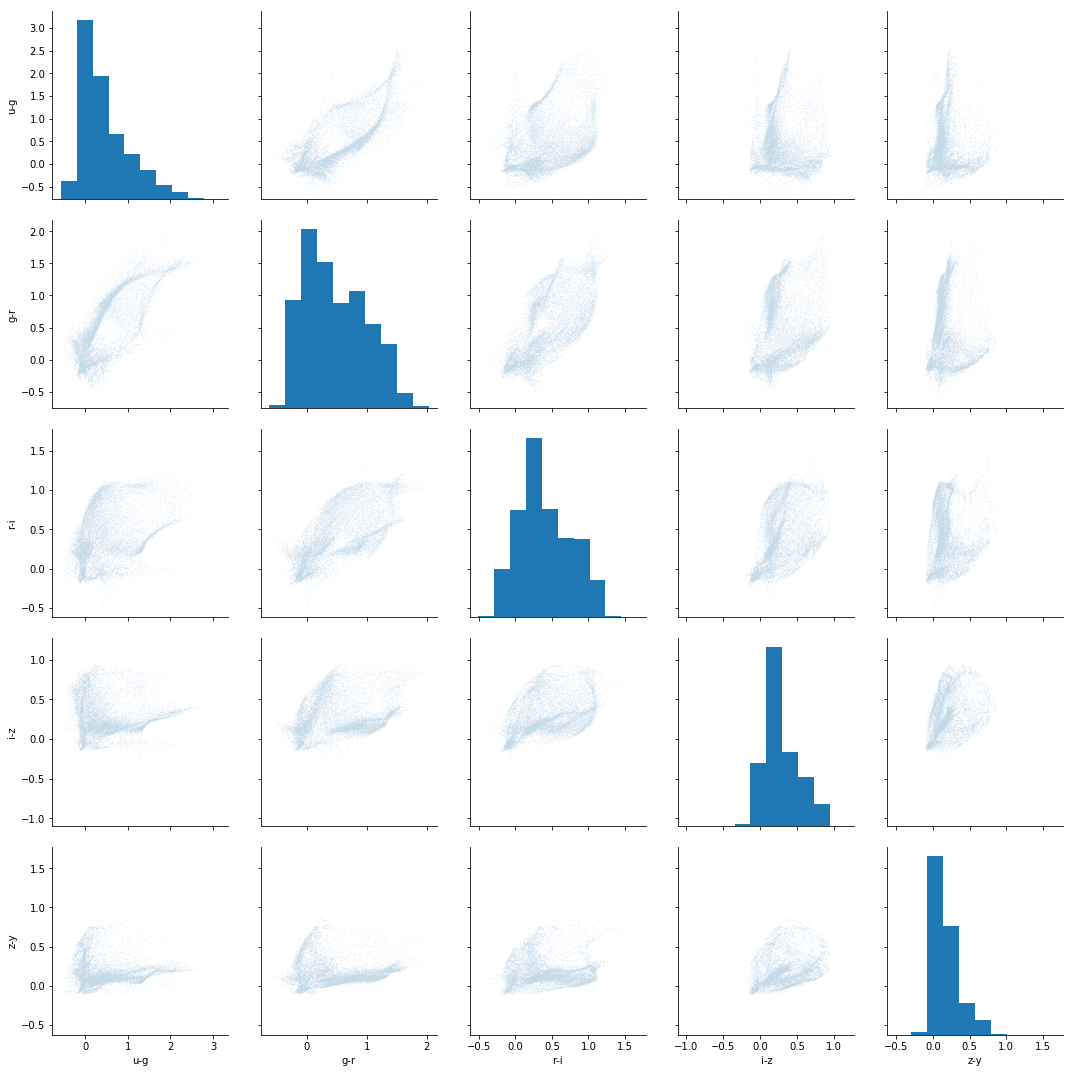

In [18]:
sns.pairplot(df[::200], kind='scatter', height=3, aspect=1, plot_kws={'s':0.5, 'alpha': 0.1})

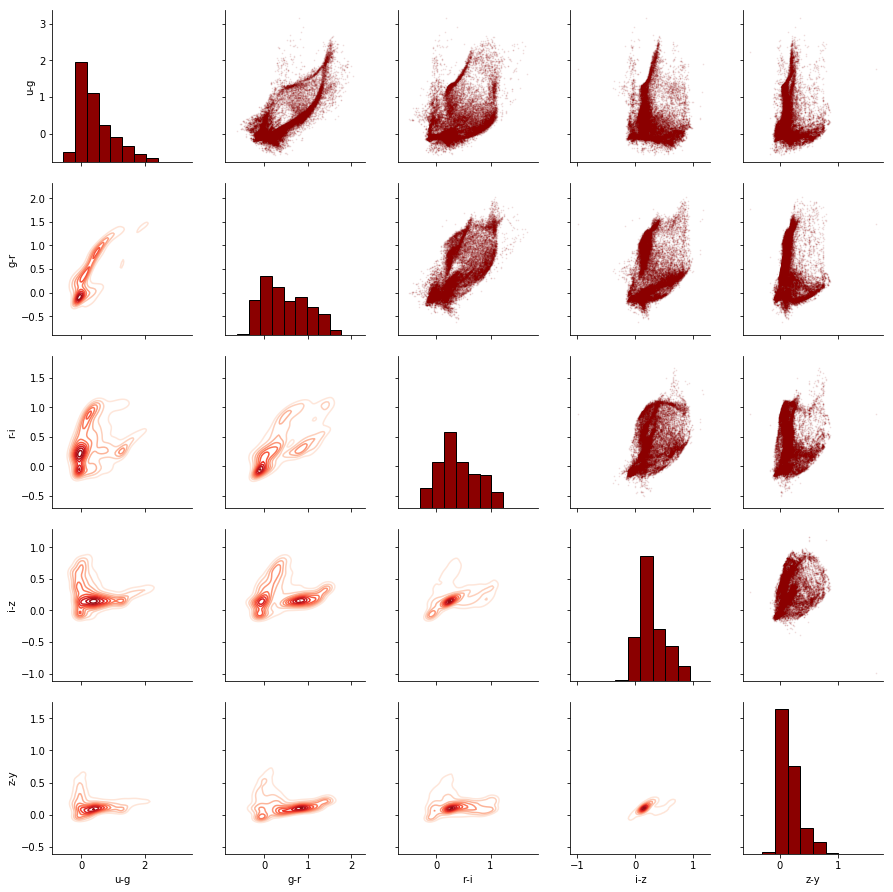

In [19]:
grid = sns.PairGrid(data=df[::200])

# Map a scatter plot to the upper triangle
grid = grid.map_upper(plt.scatter, color = 'darkred', alpha=0.1, s=0.5)

# Map a histogram to the diagonal
grid = grid.map_diag(plt.hist, bins = 10, color = 'darkred', 
                     edgecolor = 'k')
# Map a density plot to the lower triangle
grid = grid.map_lower(sns.kdeplot, cmap = 'Reds')

### Run SOM on toy dataset
Generate random points on 2D grid and see that the SOM generated from this data is similar to the orignal data (basically does it collapse to a single cell or not)

In [215]:
n_deep = int(131e3)
n_phot = 500000

rndm_deep = rng.uniform(high=10.0, size=(n_deep,3))
rndm_phot = rng.uniform(high=10.0, size=(n_phot,3))
## Generate 'target feature' (i.e. redshift) values that are correlated with the photometric sample in some way
## Will see a degeneracy in the map when sampling based on mean of all the features
rndm_z = rng.normal(loc=np.mean(rndm_phot, axis=1), scale=0.5 * np.std(rndm_phot))

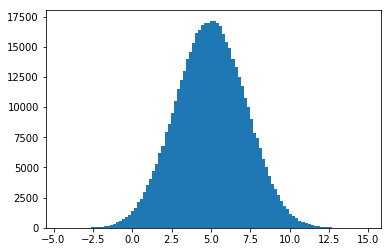

In [9]:
plt.hist(rndm_z, bins=100)
plt.show()

2D histogram of random data (10x10 grid)

In [21]:
res = -100

In [20]:
def deep_phot_hist2d(deep_data, phot_data, cols=['u-g', 'g-r'], bins=100):
    
    n_deep= len(deep_data)
    n_phot = len(phot_data)
    
    fig, axs = plt.subplots(1,2, figsize=(16,6))
    axs = axs.ravel()

    hist2d0 = np.histogram2d(deep_data[cols[0]], deep_data[cols[1]], bins=bins)
    hist2d1 = np.histogram2d(phot_data[cols[0]], phot_data[cols[1]], bins=bins)

    im0 = axs[0].hist2d(deep_data[cols[0]], deep_data[cols[1]], weights=np.ones(n_deep) / np.max(hist2d0[0]), bins=bins)
    cbar0 = fig.colorbar(im0[-1], ax=axs[0])
    cbar0.set_label('# / cell max', rotation=270, labelpad=20)
    axs[0].set_title('rndm_spec histogram')

    im1 = axs[1].hist2d(phot_data[cols[0]], phot_data[cols[1]], weights=np.ones(n_phot) / np.max(hist2d1[0]), bins=bins)
    cbar1 = fig.colorbar(im1[-1], ax=axs[1])
    cbar1.set_label('# / cell max', rotation=270, labelpad=20)
    axs[1].set_title('rndm_phot histogram')

    plt.show()

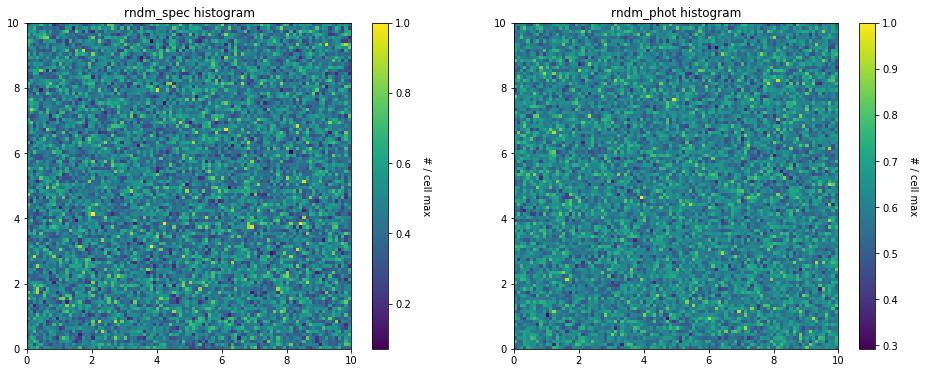

In [12]:
deep_phot_hist2d(rndm_deep, rndm_phot, np.abs(res))

### Understand 10x10 resolution SOM grid

11.313966751098633


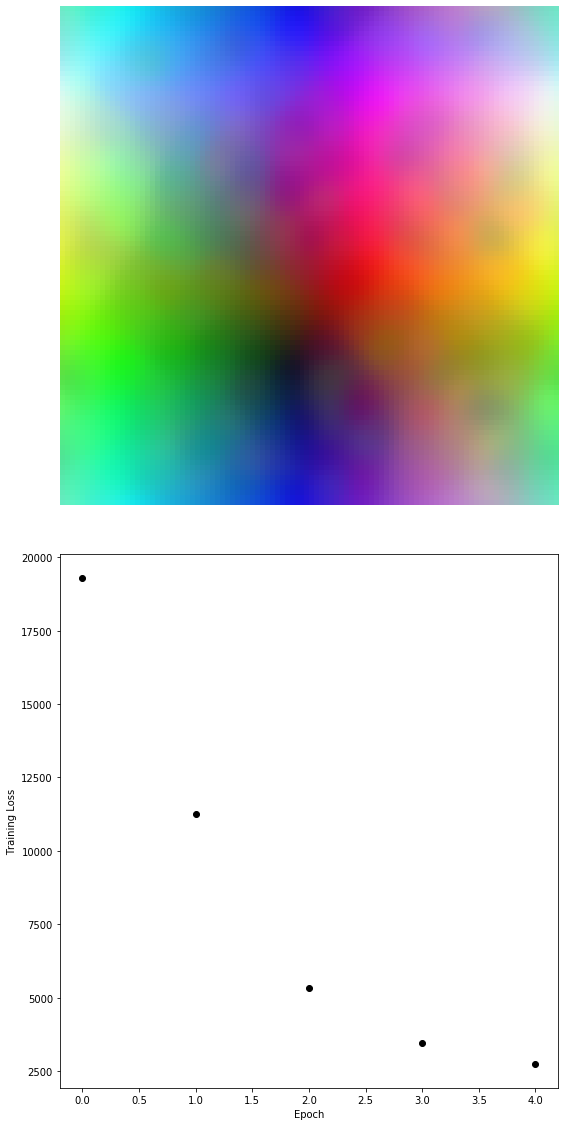

In [13]:
start = time.time()
rndm_som = make_som(rndm_deep[:5000], nmap=res, niter=5, rgb=[0,1,2])
print(time.time() - start)

4009.3544595241547


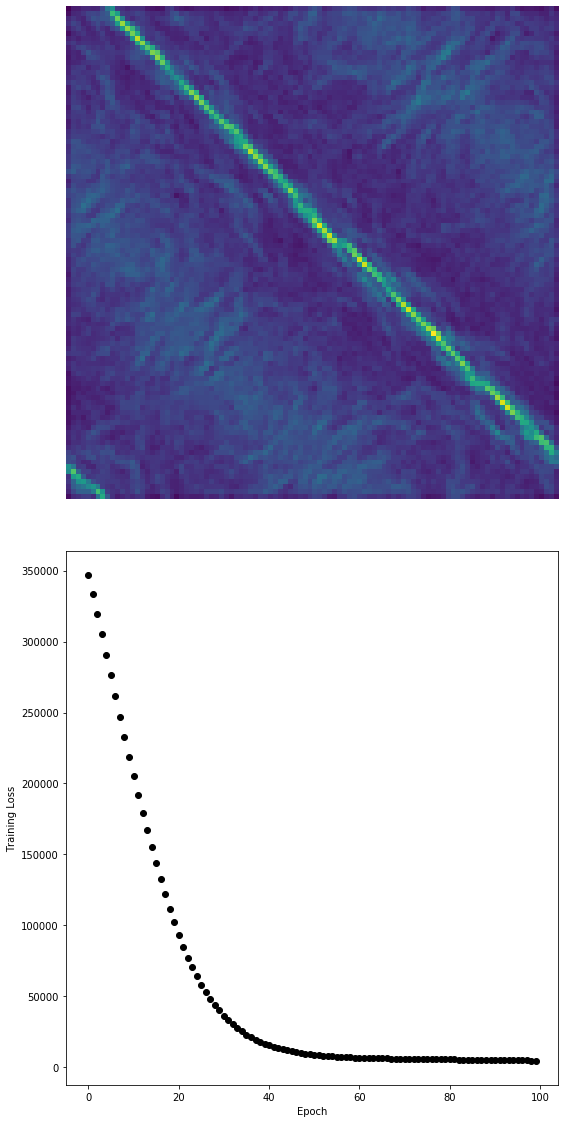

In [154]:
start = time.time()
rndm_som = make_som(rndm_deep, nmap=res, niter=100, save='../data/feature_likelihood/rndm_som')
print(time.time() - start)

Show image of each feature SOM map

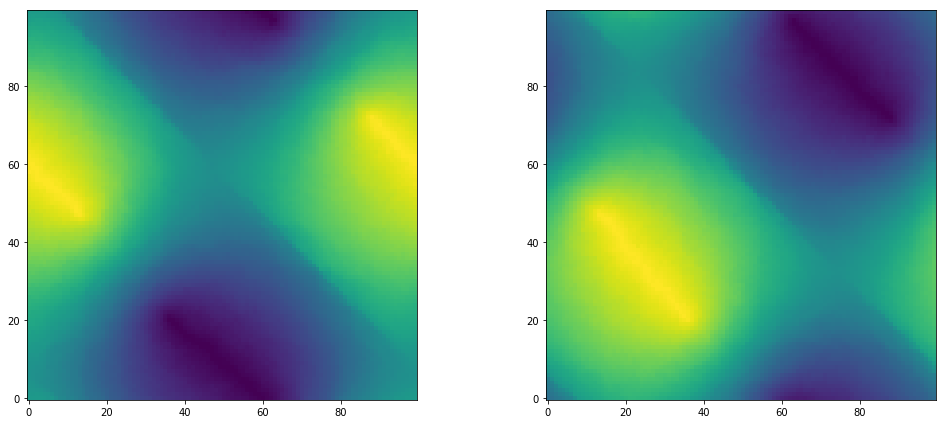

In [155]:
fig, axs = plt.subplots(1,2,figsize=(15,6))
axs = axs.ravel()

for i in range(2):
    axs[i].imshow(rndm_som[:,:,i], origin='lower', interpolation='none')
    
plt.tight_layout()
plt.show()

Make a histogram of weight values for deep sample, photometric sample, and SOM:

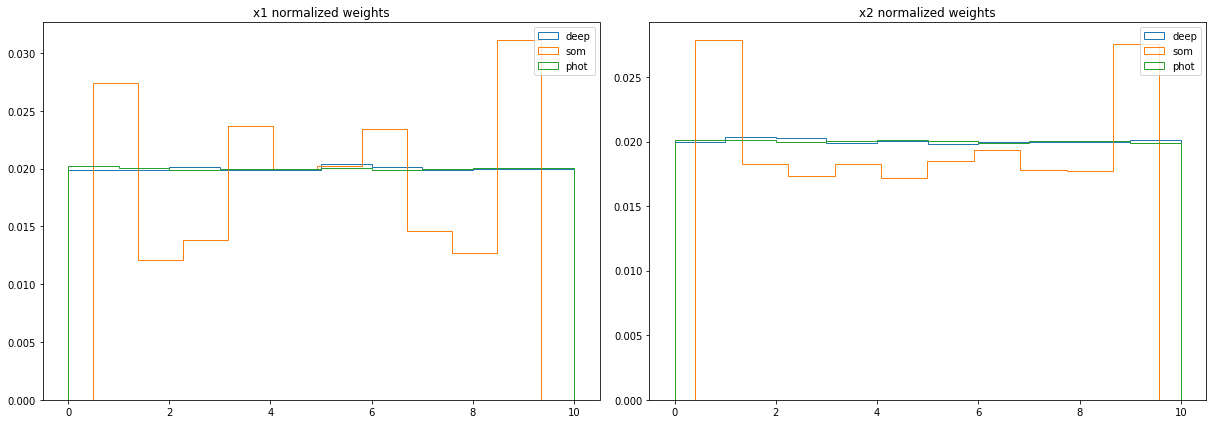

In [236]:
fig, axs = plt.subplots(1,2, figsize=(17,6))
axs = axs.ravel()

rows, cols, D = rndm_som.shape

axs[0].hist(rndm_deep[:,0], weights=np.ones(len(rndm_deep)) / np.sum(rndm_deep[:,0]), histtype='step', label='deep')
axs[0].hist(rndm_som.reshape(rows * cols, D)[:,0], weights=np.ones(rows * cols) / np.sum(rndm_som.reshape(rows * cols, D)[:,0]), histtype='step', label='som')
axs[0].hist(rndm_phot[:,0], weights=np.ones(len(rndm_phot)) / np.sum(rndm_phot[:,0]), histtype='step', label='phot')
axs[0].set_title('x1 normalized weights')
axs[0].legend()

axs[1].hist(rndm_deep[:,1], weights=np.ones(len(rndm_deep)) / np.sum(rndm_deep[:,1]), histtype='step', label='deep')
axs[1].hist(rndm_som.reshape(rows * cols, D)[:,1], weights=np.ones(rows * cols) / np.sum(rndm_som.reshape(rows * cols, D)[:,1]), histtype='step', label='som')
axs[1].hist(rndm_phot[:,1], weights=np.ones(len(rndm_phot)) / np.sum(rndm_phot[:,1]), histtype='step', label='phot')
axs[1].set_title('x2 normalized weights')
axs[1].legend()

plt.tight_layout()
plt.show()

### Map random data to SOM

In [32]:
def map_phot_to_som(data, som):
    
    '''Takes an (N, features) data array and a SOM and returns
    the flattened SOM index to which each data vector belongs, 
    as well as the number of data points mapped to each SOM cell.'''
    
    rows, cols, D = som.shape
    
    if type(data) is np.ndarray:
            pass
    else:
        colnames = data.colnames

        data_arr = np.zeros((len(data),len(colnames)))
        for k, name in enumerate(colnames):
            data_arr[:,k] = data[name]

        data = data_arr
        
    ## Calculate L2 norm distance between data weights and SOM weights
    som_indices = np.empty(len(data), dtype=int)
    for i, dat in enumerate(data):
        dx = (dat - som.reshape(rows * cols,-1))
        dist = np.sqrt(np.sum(dx ** 2, axis=1))
        som_indices[i] = np.argmin(dist)
        
    ## Determine frequency of each index on SOM resolution grid
    counts = np.bincount(som_indices, minlength=(rows * cols))
    
    return(som_indices, counts)

def plot_counts_per_cell(som_indices, som_counts, rows, cols):
    
    '''Plot number of data points mapped to each SOM cell

    Counts must have same shape as SOM grid.'''

    plt.figure(figsize=(10,7))
    plt.imshow(counts.reshape(rows,cols), origin='lower', interpolation='none', cmap='viridis')
    plt.colorbar()
    plt.title('Number per SOM cell')
    plt.show()
    
    
def plot_statistic(som_indices, som_counts, target_feature, rows, cols, statistic=np.mean):
    
    stat = np.asarray([statistic(target_feature[som_indices == i]) for i in range(rows * cols)])
    
    plt.figure(figsize=(10,7))
    plt.imshow(stat.reshape(rows,cols), origin='lower', interpolation='none', cmap='viridis')
    plt.colorbar()
    plt.title('{} of target feature per cell'.format(statistic.__name__))
    plt.show()
    

def plot_dist_in_cell(som_indices, target_feature, cols, idx=(0,0)):
        
    flattened_idx = idx[0] * cols + idx[1]
    
    plt.figure(figsize=(10,7))
    plt.hist(target_feature[som_indices == flattened_idx])
    plt.title('n(z) in bin {}'.format(idx))
    plt.xlabel('z')
    plt.ylabel('counts')
    plt.show()
    
    
def plot_sed_in_cell(data, som_indices, cols, idx=(0,0)):
    
    if type(data) is np.ndarray:
            pass
    else:
        colnames = data.colnames

        data_arr = np.zeros((len(data),len(colnames)))
        for k, name in enumerate(colnames):
            data_arr[:,k] = data[name]

        data = data_arr
    
    
    flattened_idx = idx[0] * cols + idx[1]
    gals_in_cell = data[som_indices == flattened_idx]
    rndm_idx = rng.randint(low=0, high=len(gals_in_cell), size=1)
    
    plt.figure(figsize=(10,7))
    plt.plot(gals_in_cell[rndm_idx].reshape(-1), '.')
    plt.title('SED'.format(idx))
    plt.xlabel('band')
    plt.ylabel('mag')
    plt.show()

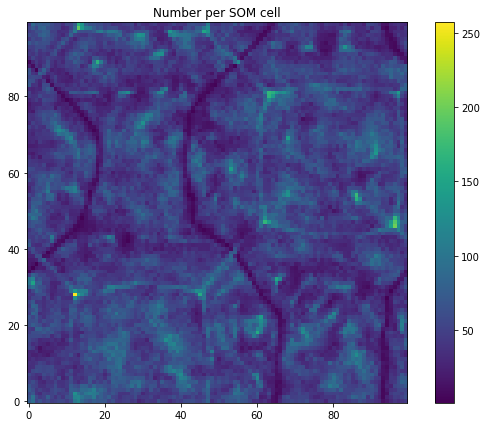

In [326]:
rows, cols, D = rndm_som.shape
som_indices, counts = map_phot_to_som(rndm_phot, rndm_som)
plot_counts_per_cell(som_indices, counts, rows, cols)

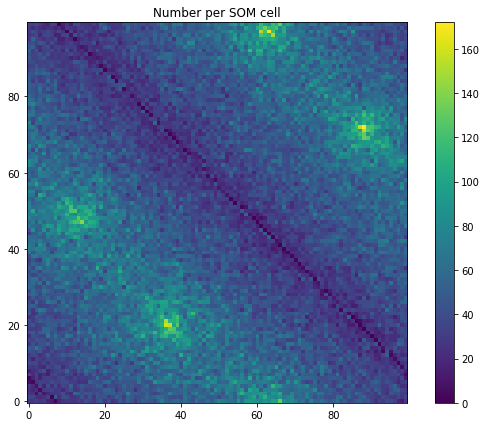

In [158]:
## This was with 100 iterations of the SOM
rows, cols, D = rndm_som.shape
som_indices, counts = map_phot_to_som(rndm_phot, rndm_som)
plot_counts_per_cell(som_indices, counts, rows, cols)

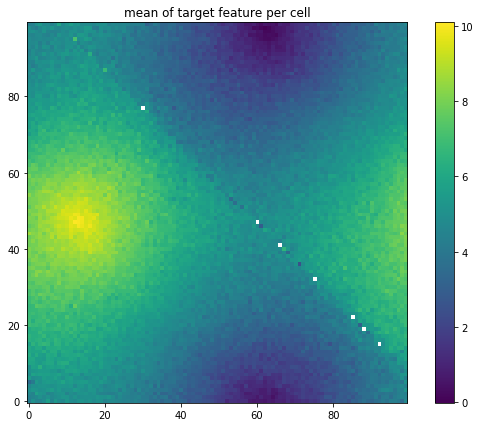

In [159]:
## This was with 100 iterations of the SOM
plot_statistic(som_indices, counts, rndm_z, rows, cols, statistic=np.mean)

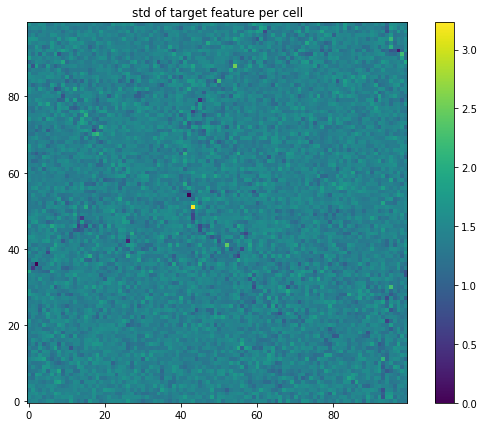

In [327]:
plot_statistic(som_indices, counts, rndm_z, rows, cols, statistic=np.std)

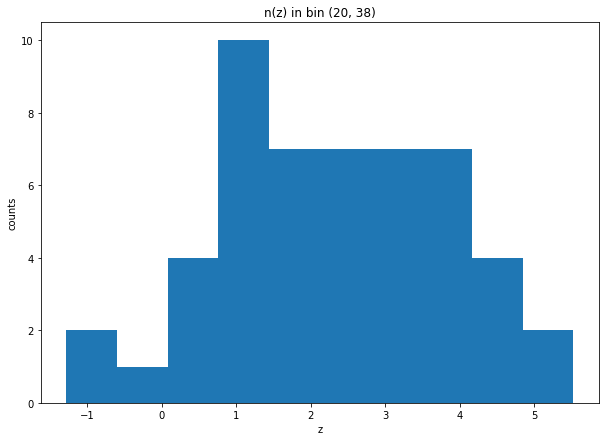

In [328]:
plot_dist_in_cell(som_indices, rndm_z, cols, idx=(20,38))

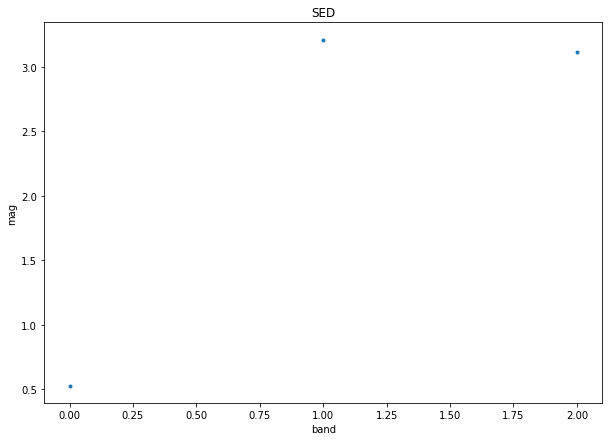

In [329]:
plot_sed_in_cell(rndm_phot, som_indices, cols, idx=(20,38))

### DC2 Diagnostic Plots

In [8]:
n_deep = 1000 #131000
n_phot = 5000

In [9]:
mags = Table.read('../data/feature_likelihood/dc2_mags.fits', format='fits')
colors = Table.read('../data/feature_likelihood/dc2_colors.fits', format='fits')
redshift = Table.read('../data/feature_likelihood/dc2_redshift.fits', format='fits')

In [36]:
dc2_deep = colors[:n_deep]
dc2_phot = colors[n_deep:n_deep + n_phot]
dc2_z = redshift[n_deep:n_deep + n_phot]
dc2_mags = mags[n_deep:n_deep + n_phot]

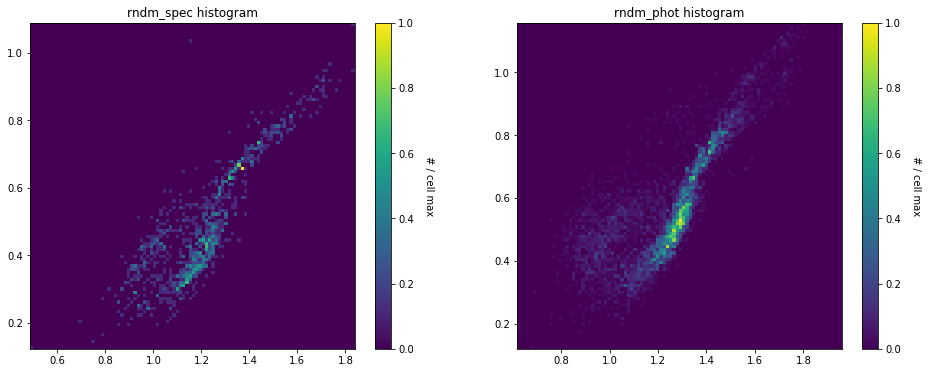

In [23]:
deep_phot_hist2d(dc2_deep, dc2_phot, cols=['u-g', 'g-r'], bins=np.abs(res))

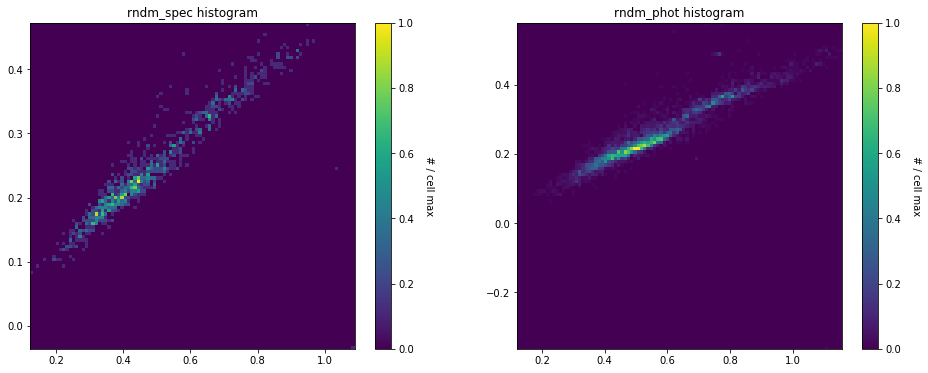

In [247]:
deep_phot_hist2d(dc2_deep, dc2_phot, cols=['g-r', 'r-i'], bins=np.abs(res))

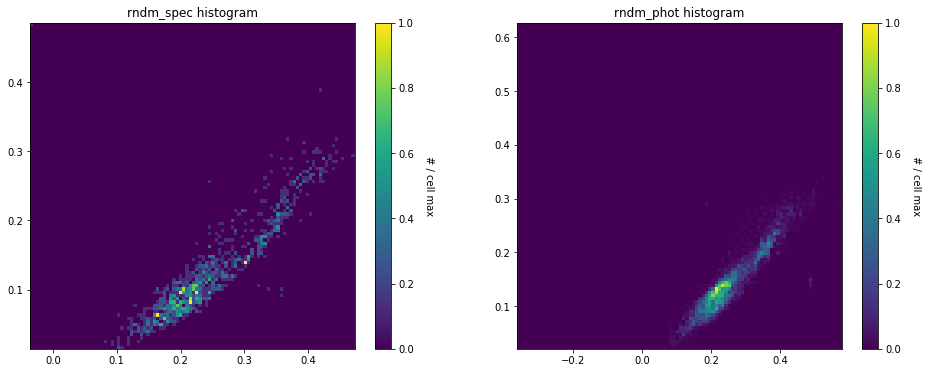

In [248]:
deep_phot_hist2d(dc2_deep, dc2_phot, cols=['r-i', 'i-z'], bins=np.abs(res))

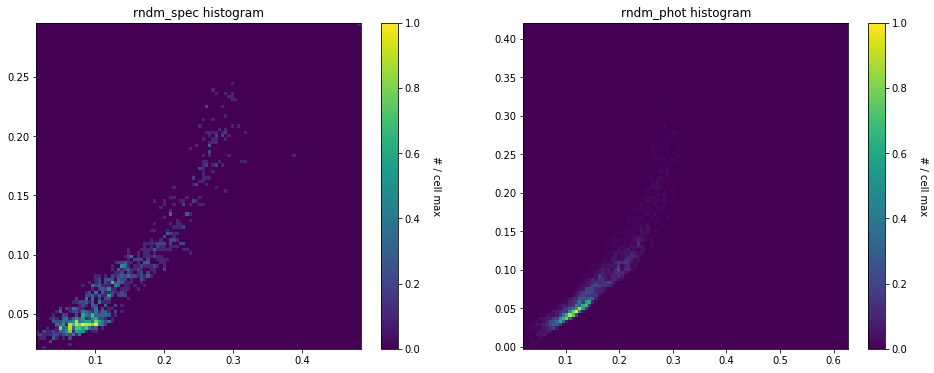

In [249]:
deep_phot_hist2d(dc2_deep, dc2_phot, cols=['i-z', 'z-y'], bins=np.abs(res))

[100, 100]
41.279317140579224


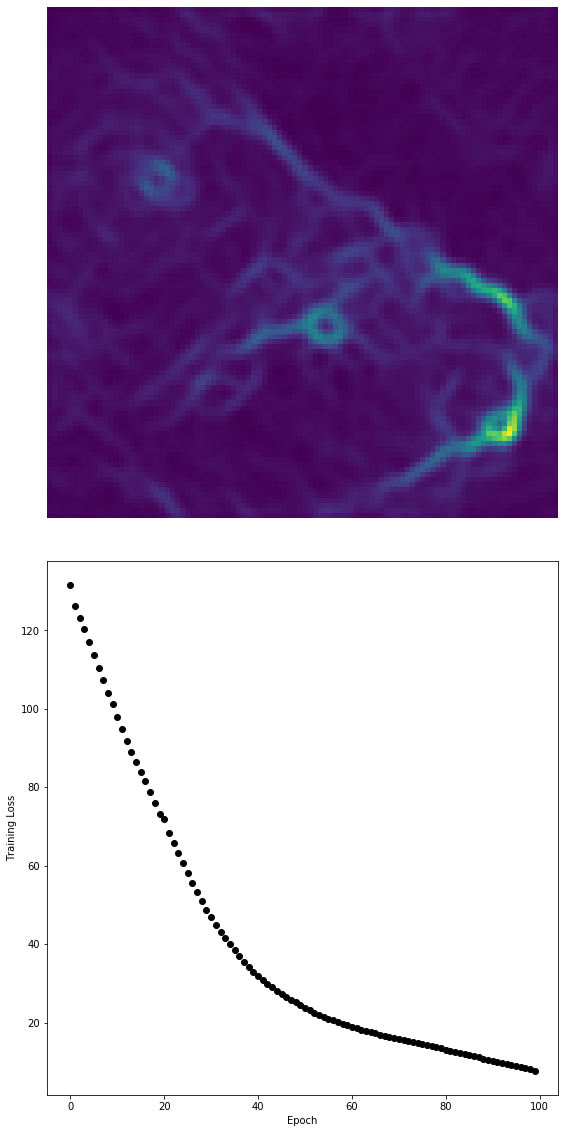

In [37]:
start = time.time()
som = make_som(dc2_deep, nmap=res, niter=100)
print(time.time() - start)

[100, 100]
20.689541578292847


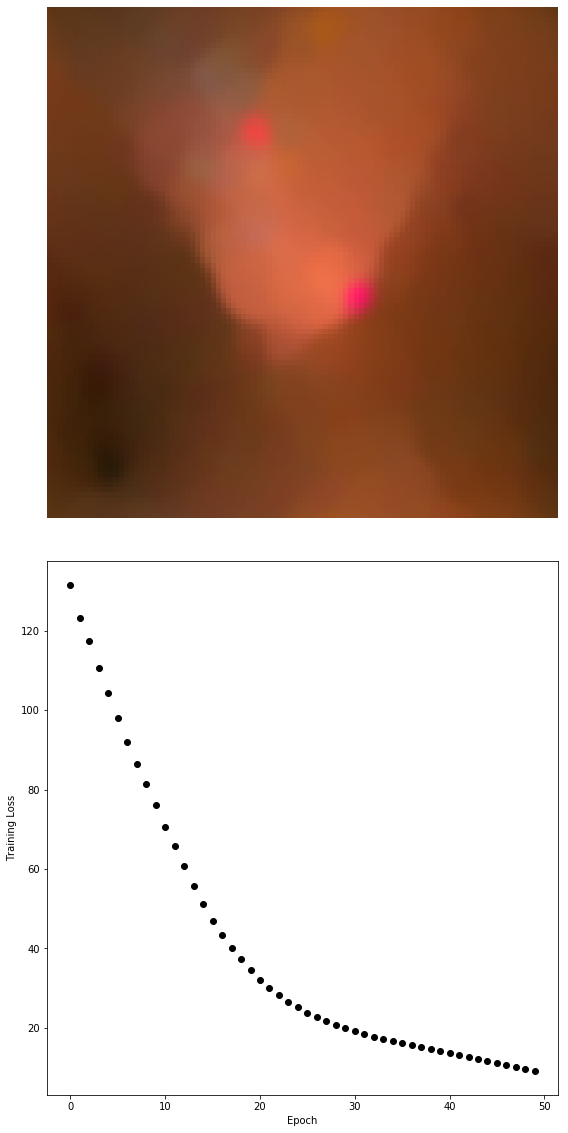

In [38]:
start = time.time()
som = make_som(dc2_deep, nmap=res, niter=50, rgb=[1,2,3])
print(time.time() - start)

629.1405477523804


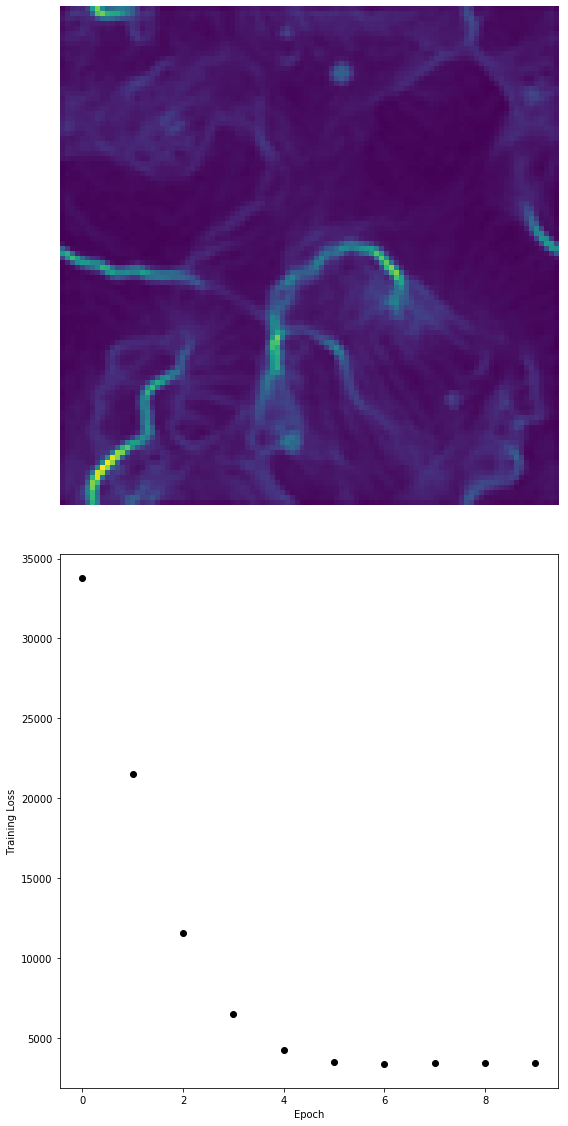

In [41]:
start = time.time()
som = make_som(dc2_deep, nmap=res, niter=10)
print(time.time() - start)

In [39]:
rows, cols, D = som.shape
som_indices, counts = map_phot_to_som(dc2_phot, som)

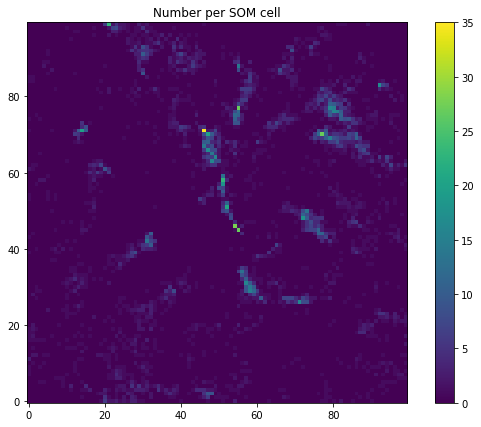

In [40]:
plot_counts_per_cell(som_indices, counts, rows, cols)

/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3115: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


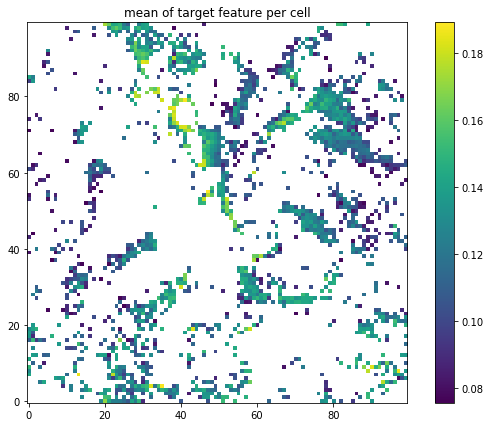

In [41]:
plot_statistic(som_indices, counts, dc2_z['redshift'], rows, cols, statistic=np.mean)

In [46]:
np.mean(dc2_z['redshift'])

0.12722727891465094

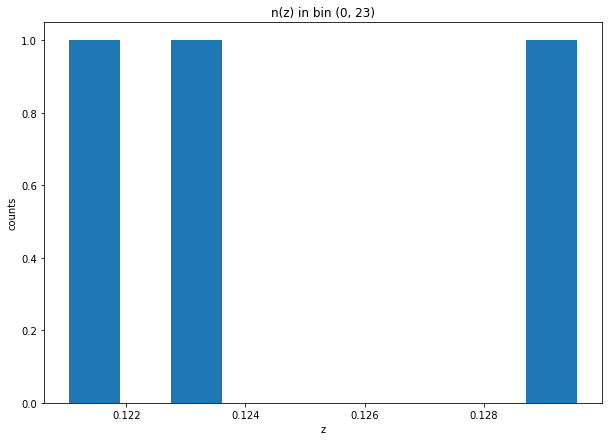

In [49]:
plot_dist_in_cell(som_indices, dc2_z['redshift'], cols, idx=(0,23))

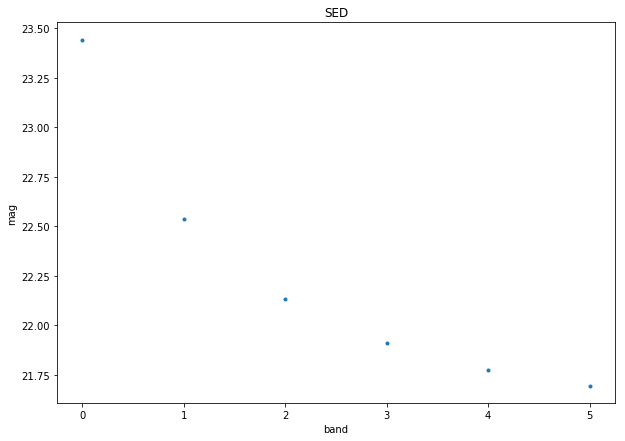

In [53]:
plot_sed_in_cell(dc2_mags, som_indices, cols, idx=(0, 23))

### Next: incorporating errors

In [10]:
rng = np.random.RandomState(seed=14)
random_idx = rng.randint(low=0, high=len(colors), size=n_deep)
dc2_deep = colors[random_idx]

In [11]:
filters = ['u', 'g', 'r', 'i', 'z', 'y']
for band in filters:
    print(np.std(mags[band]))

1.3667894376644347
1.165811526969623
1.1817476601950068
1.2819513700021443
1.3410144897581024
1.3698245239758122


In [98]:
def select_colors(color_data, color):
    
    #sig1 = np.std(mags[band1])
    #sig2 = np.std(mags[band2])
    #err = np.sqrt(sig1 ** 2 + sig2 ** 2)
    
    err = np.std(color_data[color])
    mu = color_data[color]
    
    return(rng.normal(loc=mu, scale=np.full(len(color_data), err)))

In [89]:
s = select_colors(colors[random_idx], 'u-g')
#s, err = select_color(colors[random_idx], 'u-g')

In [82]:
err

0.5815929095846144

In [83]:
np.std(colors['u-g'])

0.5889802524122273

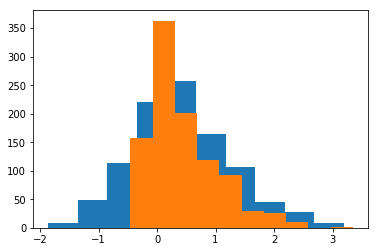

In [84]:
plt.hist(s)
plt.hist(colors[random_idx]['u-g'])
plt.show()

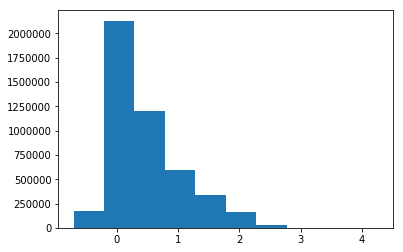

In [86]:
plt.hist(colors['u-g'])
plt.show()

Is sampling from a Gaussian going to be accurate? Colors don't look normally-distributed ...

In [120]:
def add_errs(colors):
    
    u_g = select_colors(colors, 'u-g')
    g_r = select_colors(colors, 'g-r')
    r_i = select_colors(colors, 'r-i')
    i_z = select_colors(colors, 'i-z')
    z_y = select_colors(colors, 'z-y')
    
    colors_w_errs = np.asarray([u_g, g_r, r_i, i_z, z_y]).T
    
    return(Table(colors_w_errs, names=['u-g', 'g-r', 'r-i', 'i-z', 'z-y']))

In [121]:
colors_w_errs = add_errs(colors)

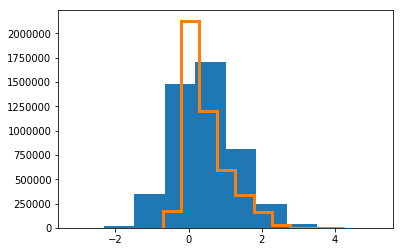

In [123]:
plt.hist(colors_w_errs['u-g'])
plt.hist(colors['u-g'], histtype='step', lw=3)
plt.show()

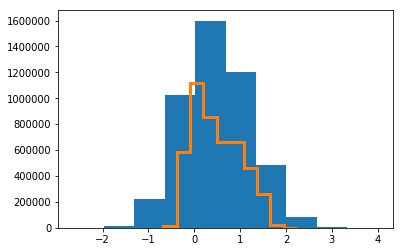

In [124]:
plt.hist(colors_w_errs['g-r'])
plt.hist(colors['g-r'], histtype='step', lw=3)
plt.show()

In [125]:
len(colors_w_errs), len(colors)

(4631406, 4631406)

[100, 100]
43.157453298568726


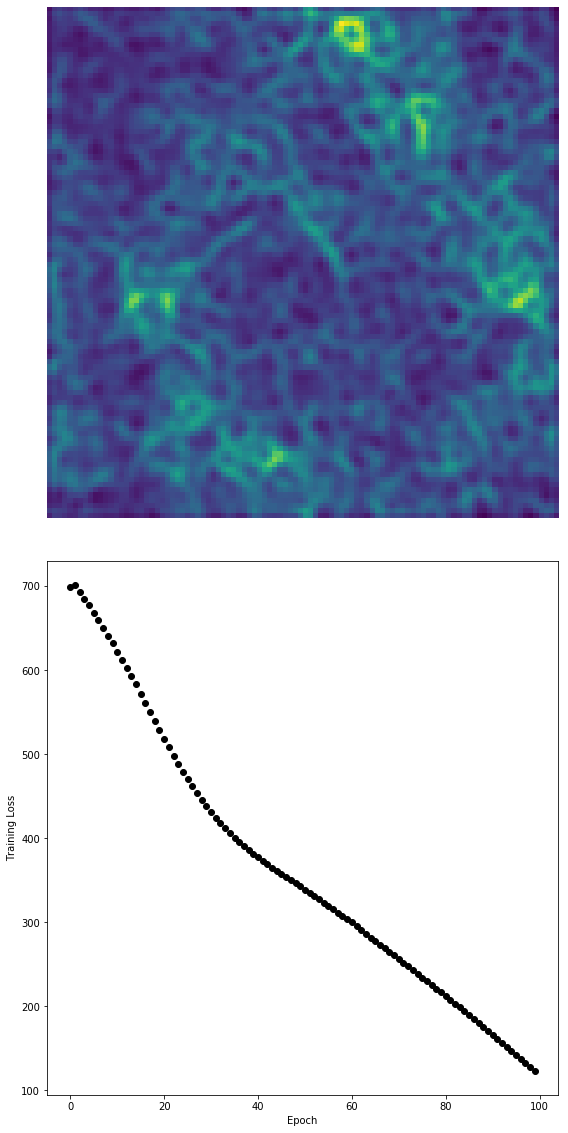

In [128]:
start = time.time()
som_w_errs = make_som(colors_w_errs[:1000], nmap=res, niter=100)
print(time.time() - start)

In [130]:
test = np.load('/global/cscratch1/sd/belaa/lsst/pz/batch_scripts/som_output/dc2_som_131000_100.npy')

In [132]:
test_img = u_matrix(test)

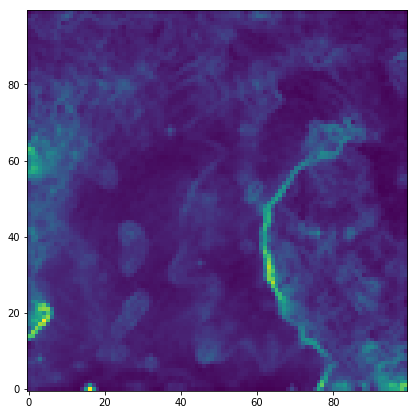

In [136]:
plt.figure(figsize=(10,7))
plt.imshow(test_img, origin='low', interpolation='none')
plt.show()

#### Incorporate errors into SOM (still using random sample)

In [41]:
rng = np.random.RandomState(seed=14)
## Fewer galaxies (2000 vs 5000)
rndm_deep = rng.uniform(size=(2000,2))

7.145280838012695


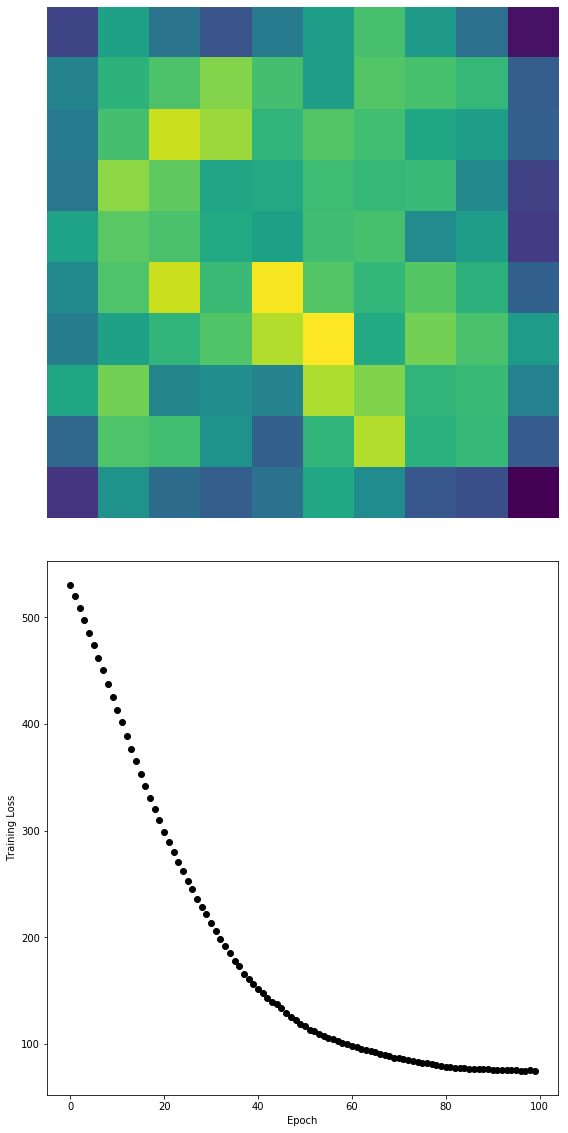

In [42]:
res = -10
start = time.time()
rndm_som = galaxy_demo(rndm_deep, nmap=res)
print(time.time() - start)

In [43]:
# New dataset with same seed (to simulate deep sample vs photometric sample)
rndm_phot = rng.uniform(size=(5000,2))
rndm_z = rng.uniform(low=0.0, high=3.0, size=n_phot)

In [44]:
# Generate random errors for each feature
sig1 = 0.006 # mean error in i-band
sig2 = 0.002 # mean error in r-band
errs = rng.multivariate_normal(mean=(sig1, sig2), cov=[[0.001 ** 2, 0], [0, 0.0005 ** 2]], size=len(rndm_phot))

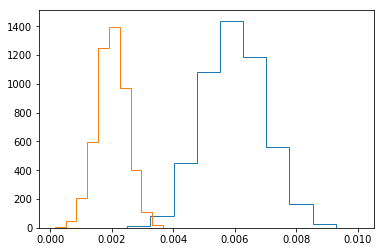

In [45]:
# Make sure errors are > 0
plt.hist(errs[:,0], histtype='step')
plt.hist(errs[:,1], histtype='step')
plt.show()

In [46]:
# Want to map random points to SOM cells while accounting for the errors in each feature
# Assume features independent of each other (i.e. diagonal covariance, not realistic)

sampled = np.zeros_like(rndm_phot)
for i, dat in enumerate(rndm_phot):
    sampled[i] = rng.multivariate_normal(mean=dat, cov=[[errs[i][0] ** 2, 0],[0, errs[i][1] ** 2]], size=1)

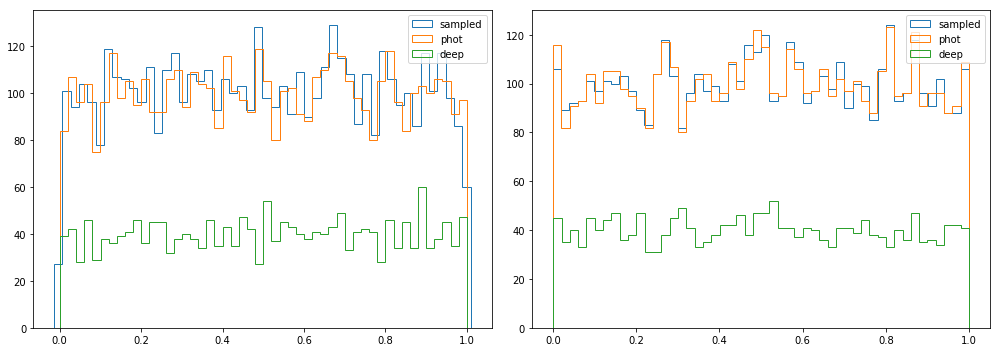

In [47]:
fig, axs = plt.subplots(1,2, figsize=(14,5))
axs = axs.ravel()

axs[0].hist(sampled[:,0], bins=50, histtype='step', label='sampled')
axs[0].hist(rndm_phot[:,0], bins=50, histtype='step', label='phot')
axs[0].hist(rndm_deep[:,0], bins=50, histtype='step', label='deep')
axs[0].legend()

axs[1].hist(sampled[:,1], bins=50, histtype='step', label='sampled')
axs[1].hist(rndm_phot[:,1], bins=50, histtype='step', label='phot')
axs[1].hist(rndm_deep[:,1], bins=50, histtype='step', label='deep')
axs[1].legend()

plt.tight_layout()
plt.show()

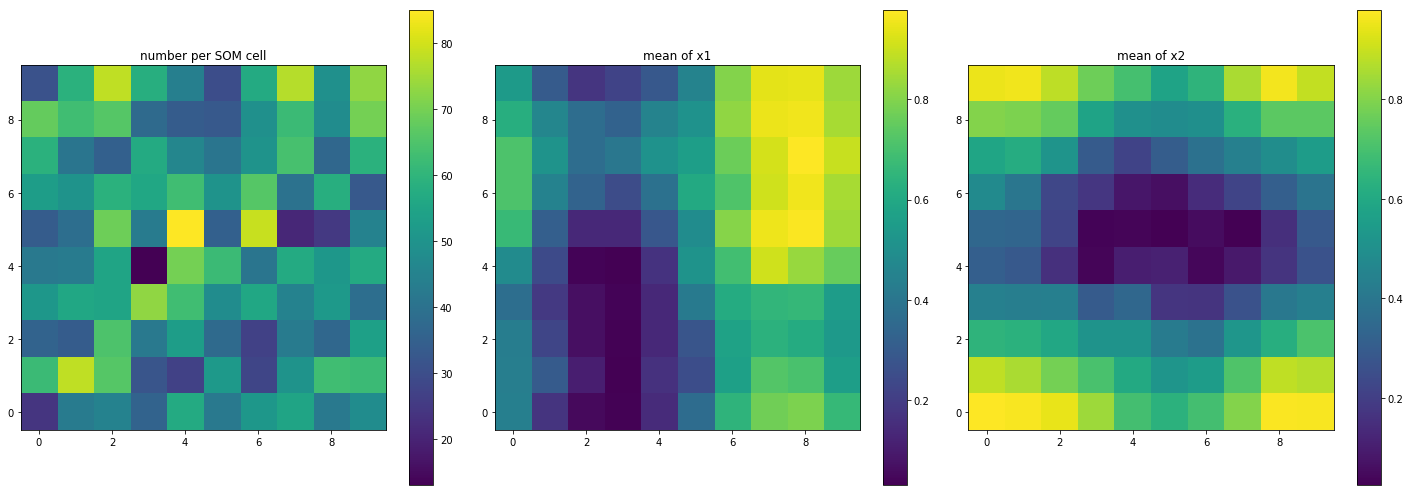

In [48]:
map_rndm_to_som(sampled, rndm_som_10, statistic=np.mean)

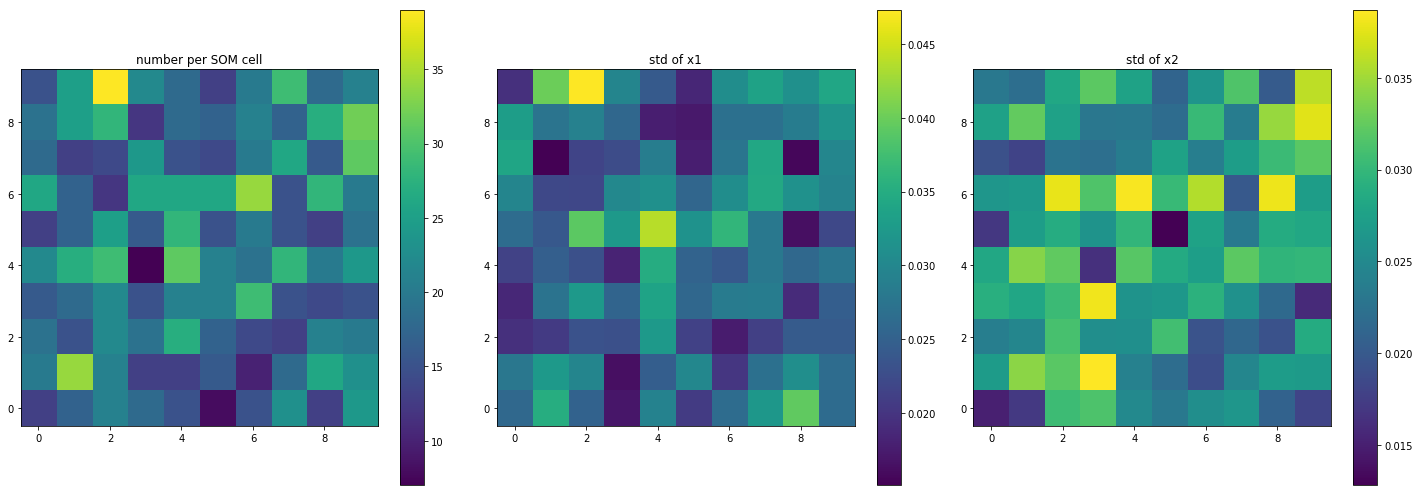

In [51]:
map_rndm_to_som(rndm_deep, rndm_som_10, statistic=np.std)

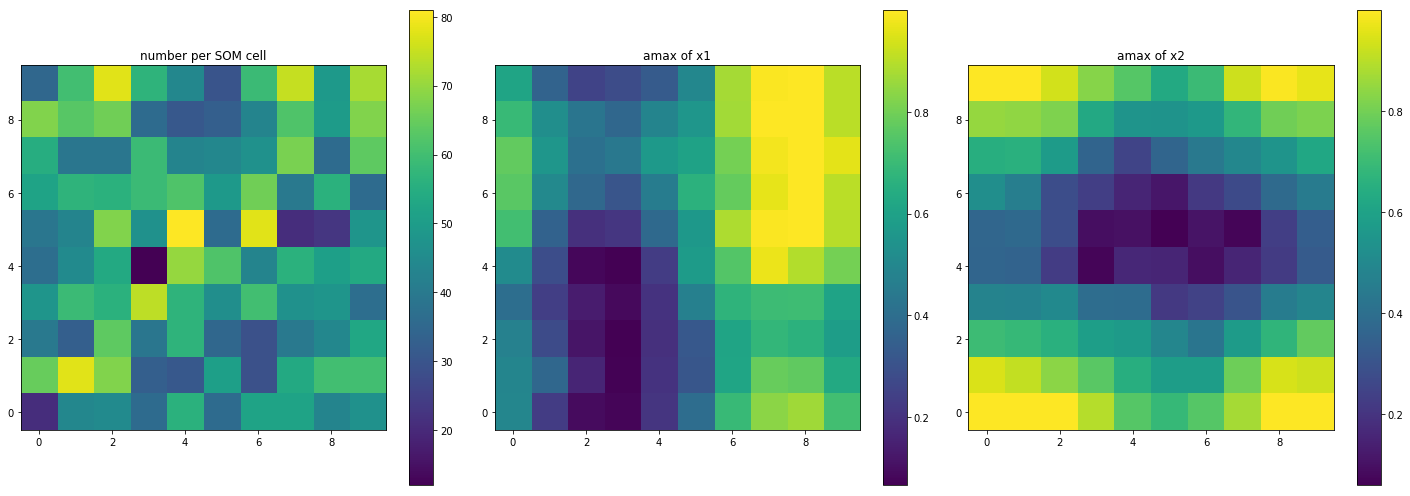

In [52]:
map_rndm_to_som(rndm_phot, rndm_som_10, statistic=np.max)

In [53]:
def quant_error(phot_data, som_indices, som_weights):
    
    """Average quantization error (from Masters et al. 2015 Eq. 7)"""
    
    N = len(phot_data)
    
    dx = phot_data - som_weights[som_indices,:]
    dist = np.sqrt(np.sum(dx ** 2))
    qe = np.sum(dist, axis=0) / N
    
    return(qe)

In [60]:
n_deep = 2000
n_phot = 5000

means=(0.006, 0.002)
cov=[[0.001 ** 2, 0], [0, 0.0005 ** 2]]

deep_sample = rng.uniform(size=(n_deep,2))
phot_sample = rng.uniform(size=(n_phot,2))
#errs = rng.multivariate_normal(mean=means, cov=cov, size=len(phot_sample))

def random_demo(rndm_deep, rndm_phot, nofz_index=None, res=-10, statistic=np.mean):
    
    """1. Plots 2D histogram of deep sample
       2. Plot of SOM and loss function (based on deep sample)
       3. Diagnostic plots based on some statistic
       4. n(z) for a specified cell
       5. Quantization error"""
    
    # 2D histogram of deep sample
    plt.figure(figsize=(8,7))
    plt.hist2d(rndm_deep[:,0], rndm_deep[:,1], bins=np.abs(res))
    plt.colorbar()
    plt.show()
    
    # Make SOM from deep sample
    start = time.time()
    rndm_som, rndm_weights = galaxy_demo(rndm_deep, nmap=res)
    print("Took {} seconds to make SOM.".format(time.time() - start))
    
    
    # Sample photometric data with errors
    #sampled = np.zeros_like(phot_sample)
    #for i, dat in enumerate(phot_sample):
        #sampled[i] = rng.multivariate_normal(mean=dat, cov=[[errs[i][0] ** 2, 0],[0, errs[i][1] ** 2]], size=1)
          
    # Map sampled data to SOM
    #som_indices = map_galaxies_to_som(sampled, rndm_som, statistic=statistic, return_indices=True)
    som_indices = map_rndm_to_som(sampled, rndm_som, statistic=statistic)
    
    #som_cell = np.abs(res) * nofz_index[0] + nofz_index[1] 
    #nofz = redshifts[som_indices == som_cell]
    
    plt.hist(nofz)
    plt.title('{} galaxies in SOM cell {}'.format(len(nofz), nofz_index))
    plt.show()
    
    print(quant_error(phot_sample, som_indices, som_weights))

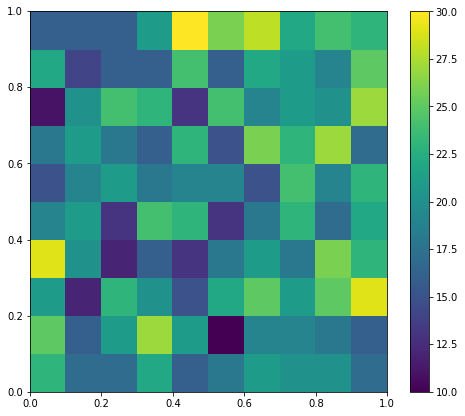

Took 7.086543798446655 seconds to make SOM.


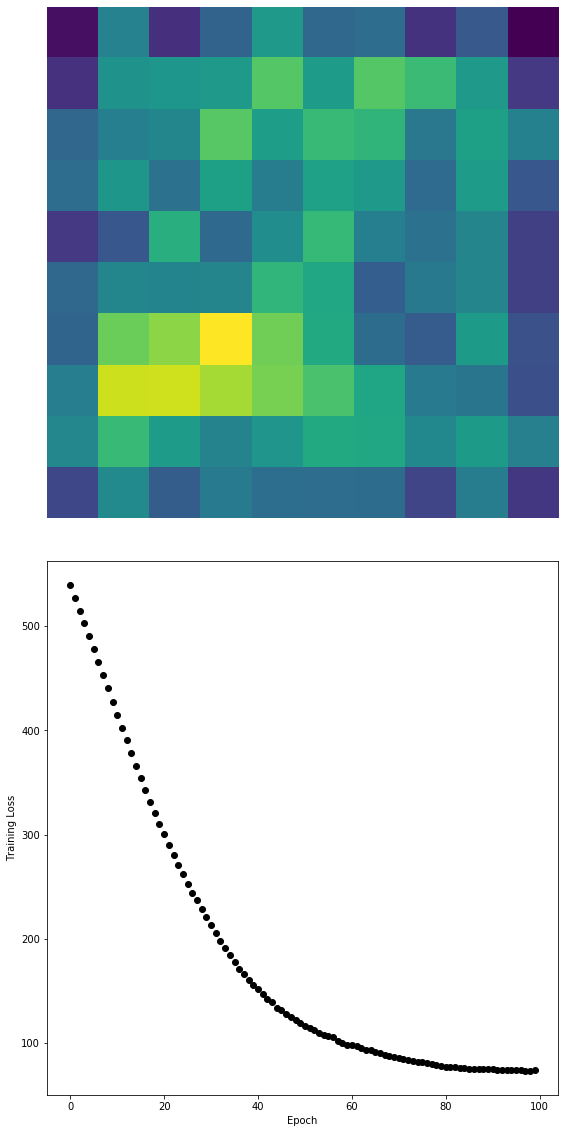

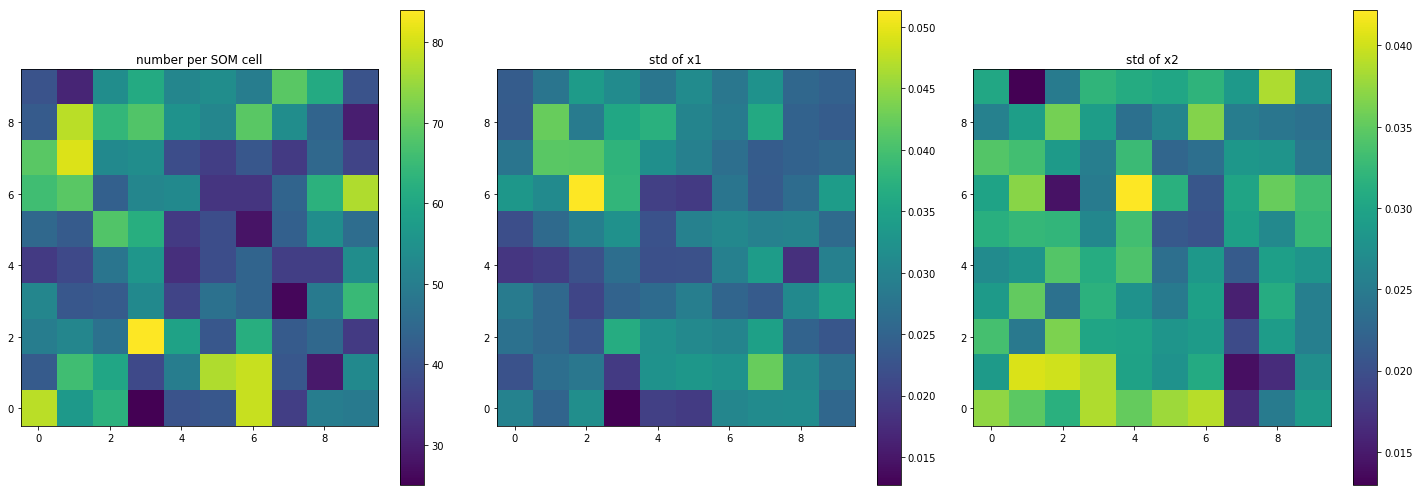

IndexError: boolean index did not match indexed array along dimension 0; dimension is 5000 but corresponding boolean dimension is 100

In [61]:
random_demo(deep_sample, phot_sample, redshifts, errs, means, cov, nofz_index = (4,3), statistic=np.std)

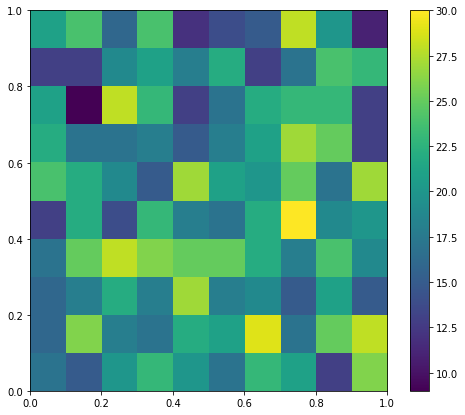

Took 5.5118491649627686 seconds to make SOM.


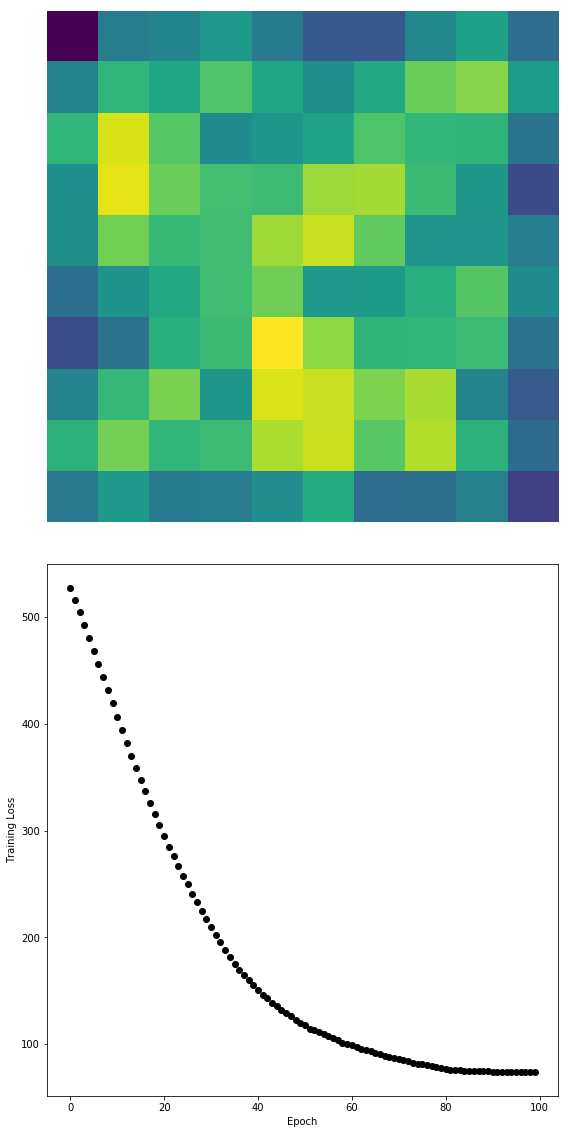

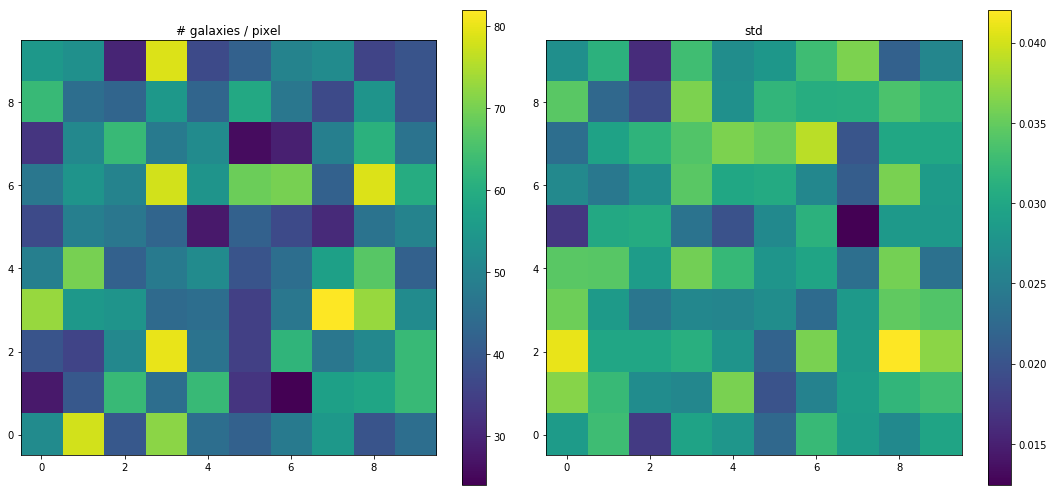

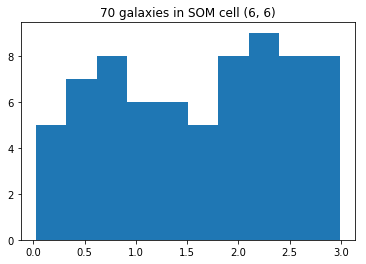

0.0006323275139454102


In [268]:
random_demo(rng, n_deep=2000, n_phot=5000, means=(0.006, 0.002), cov=[[0.001 ** 2, 0], [0, 0.0005 ** 2]], 
            nofz_index=(6,6), statistic=np.std)

Decrease number of galaxies in deep sample to 10% of photometric sample:

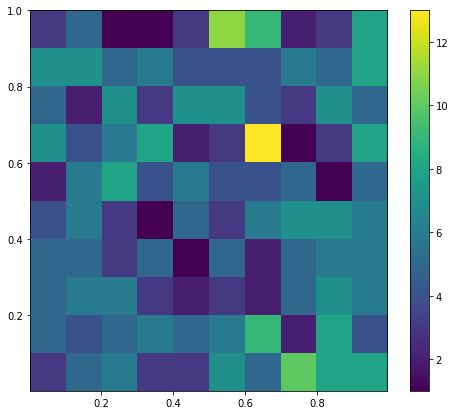

Took 1.5345079898834229 seconds to make SOM.


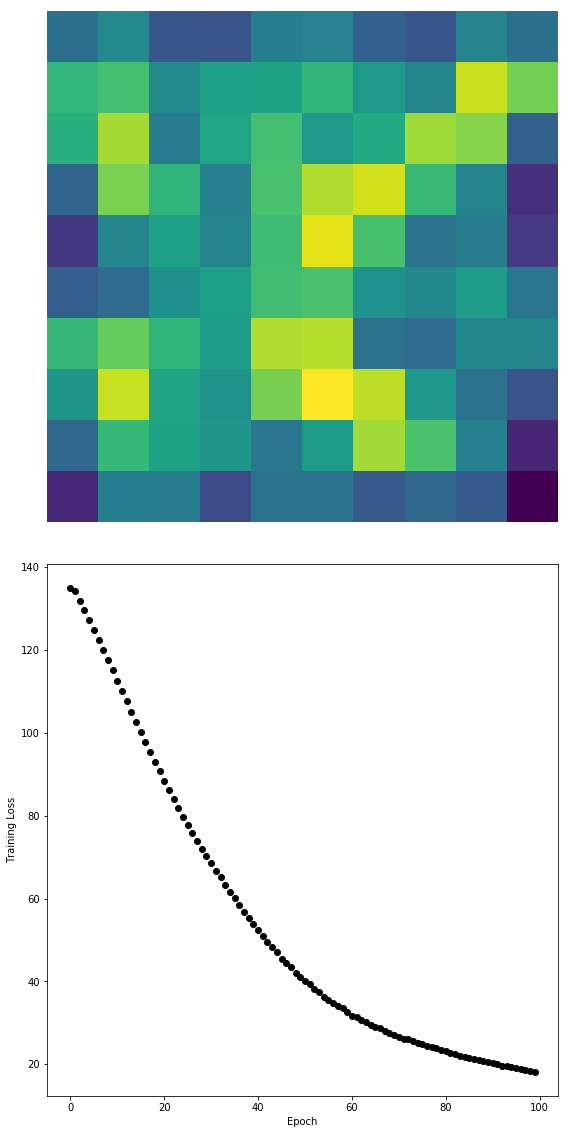

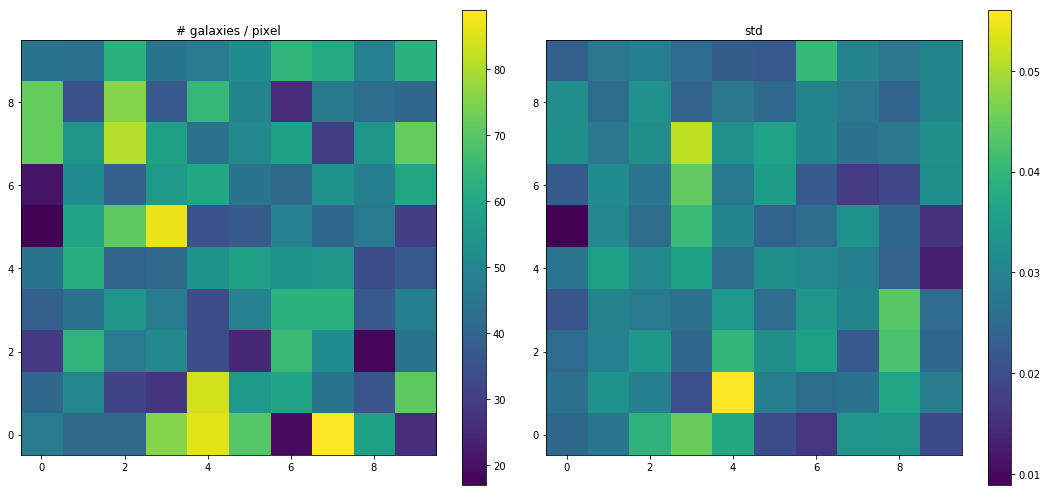

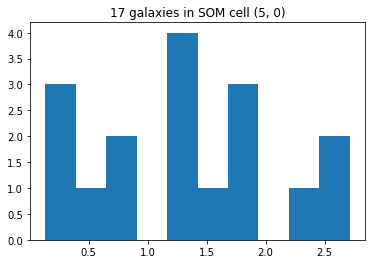

0.0006762227547523629


In [267]:
random_demo(rng, n_deep=500, n_phot=5000, means=(0.006, 0.002), cov=[[0.001 ** 2, 0], [0, 0.0005 ** 2]], 
           nofz_index=(5,0), statistic=np.std)

Decrease number of galaxies in deep sample to 1% of photometric sample:

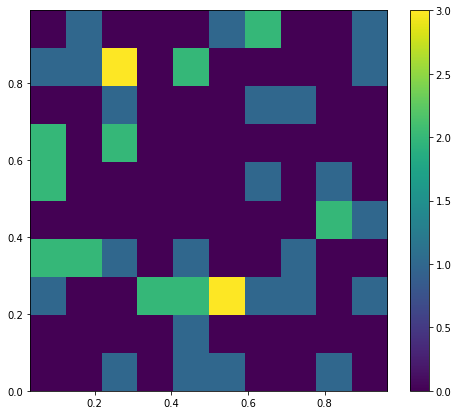

Took 0.28114795684814453 seconds to make SOM.


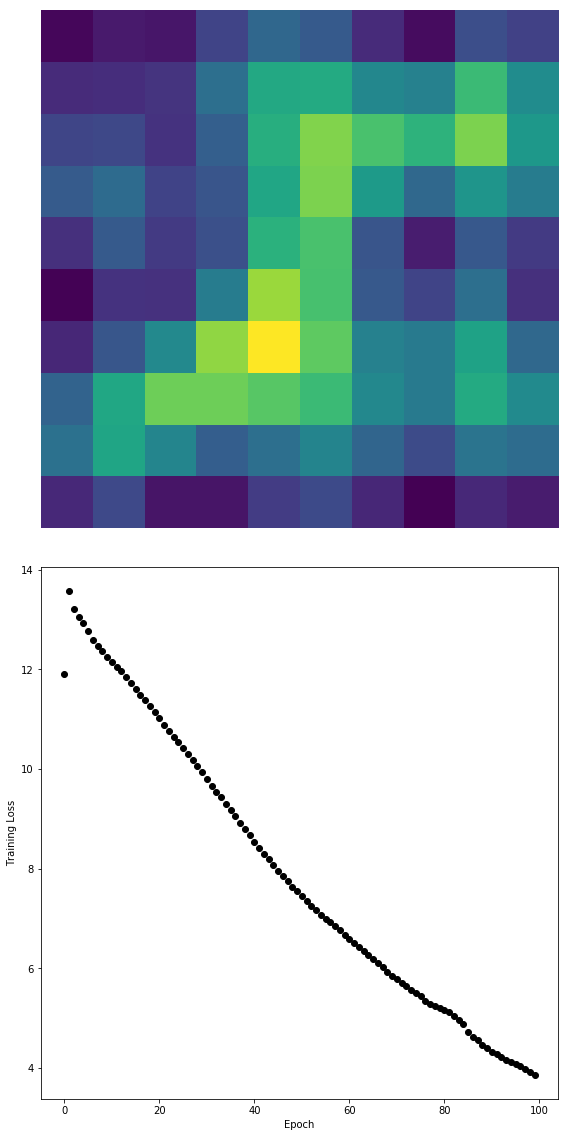

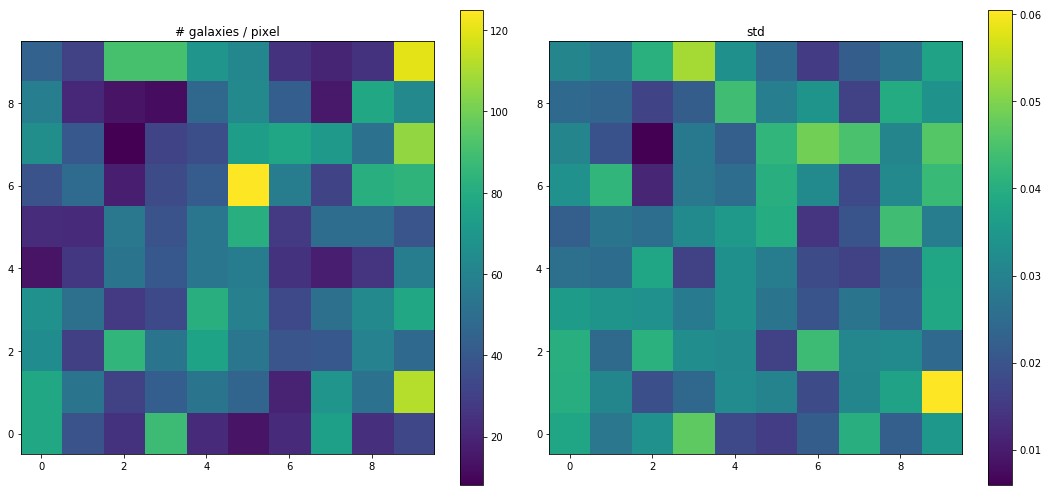

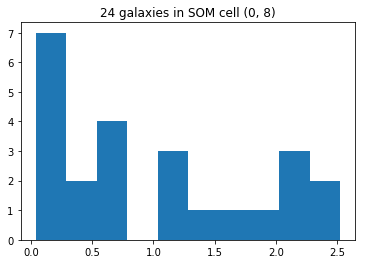

0.0008035497308289638


In [266]:
random_demo(rng, n_deep=50, n_phot=5000, means=(0.006, 0.002), cov=[[0.001 ** 2, 0], [0, 0.0005 ** 2]], 
           nofz_index=(0,8), statistic=np.std)

From Cori: 

### Adding photometric errors to the SOM

Get photometric error catalog via GCR:

In [ ]:
gc_err = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small_photoz_magerr_10y')

In [ ]:
gc_err_mag_cut = gc_err.get_quantities(['ra', 'dec', 'redshift', 'mag_i', 'mag_g','mag_r', 'mag_u', 'mag_y', 'mag_z', 'scaterr_i', 
                                   'scaterr_g', 'scaterr_r', 'scaterr_u', 'scaterr_y', 'scaterr_z'], filters=(coord_filters + mag_filters))

In [ ]:
assert len(gc_data_mag_cut['ra']) == len(gc_err_mag_cut['ra'])
assert np.all(gc_data_mag_cut['ra'] == gc_err_mag_cut['ra'])

In [ ]:
def propogate_mag_errs(err_band1, err_band2):
    return(np.sqrt(err_band1 ** 2 + err_band2 ** 2))

In [ ]:
u = gc_err_mag_cut['mag_u']
g = gc_err_mag_cut['mag_g']
r = gc_err_mag_cut['mag_r']
i = gc_err_mag_cut['mag_i']
z = gc_err_mag_cut['mag_z']
y = gc_err_mag_cut['mag_y']

err_u = gc_err_mag_cut['scaterr_u']
err_g = gc_err_mag_cut['scaterr_g']
err_r = gc_err_mag_cut['scaterr_r']
err_i = gc_err_mag_cut['scaterr_i']
err_z = gc_err_mag_cut['scaterr_z']
err_y = gc_err_mag_cut['scaterr_y']

In [ ]:
u_g = u - g
g_r = g - r
r_i = r - i
i_z = i - z
z_y = z - y

err_u_g = propogate_mag_errs(u, g)
err_g_r = propogate_mag_errs(g, r)
err_r_i = propogate_mag_errs(r, i)
err_i_z = propogate_mag_errs(i, z)
err_z_y = propogate_mag_errs(z, y)

redshifts = gc_err_mag_cut['redshift']

colors = np.asarray([u_g, g_r, r_i, i_z, z_y]).T
errs = np.asarray([err_u_g, err_g_r, err_r_i, err_i_z, err_z_y]).T

In [ ]:
err_i = gc_err_mag_cut['scaterr_i'][::50]
err_g = gc_err_mag_cut['scaterr_g'][::50]
err_r = gc_err_mag_cut['scaterr_r'][::50]
err_u = gc_err_mag_cut['scaterr_u'][::50]
err_y = gc_err_mag_cut['scaterr_y'][::50]
err_z = gc_err_mag_cut['scaterr_z'][::50]

In [ ]:
plt.figure(figsize=(10,7))
plt.hist([err_u, err_g, err_r, err_i, err_z, err_y], bins=np.percentile(err_i, (np.arange(50))), histtype='step', range=(0,0.5), label=['err_u', 'err_g', 'err_r', 'err_i', 'err_z', 'err_y'])
plt.legend()
plt.show()

In [ ]:
plt.errorbar(x=np.arange(50), y=gc_err_mag_cut['mag_i'][:50], yerr=err_i, fmt='.')
plt.show()

In [ ]:
# fractional error
gc_err_mag_cut['scaterr_i'][:50] / gc_err_mag_cut['mag_i'][:50]

In [ ]:
## Using chi-squared distance to calculated neighborhood
res = -10
start = time.time()
som_10 = galaxy_demo(colors[::200], errs[::200], nmap=res)
print(time.time() - start)

In [ ]:
counts = map_galaxies_to_som(colors[::100], redshifts[::100], som_10, statistic=np.mean, scale=1000)a

In [ ]:
counts = map_galaxies_to_som(colors[::50], redshifts[::50], som_10, statistic=np.mean, scale=1000)

In [ ]:
counts = map_galaxies_to_som(colors[::10], redshifts[::10], som_10, statistic=np.mean, scale=1000)

In [ ]:
## Using chi-squared distance to calculated neighborhood
res = -32
start = time.time()
som_32 = galaxy_demo(colors[::100], errs[::100], nmap=res)
print(time.time() - start)

In [ ]:
counts = map_galaxies_to_som(colors[::100], redshifts[::100], som_32, statistic=np.mean, scale=1000)

In [ ]:
## Using chi-squared distance to calculated neighborhood
res = -100
start = time.time()
som_100 = galaxy_demo(colors[::100], errs[::100], nmap=res)
print(time.time() - start)

## In progress..

- Consider using more galaxies to make the som (then gradually decrease to see how it degrades the SOM)
- Look at masters som paper to get a feel for what parameters to use for SOM

(3, 1024)
119.52241897583008


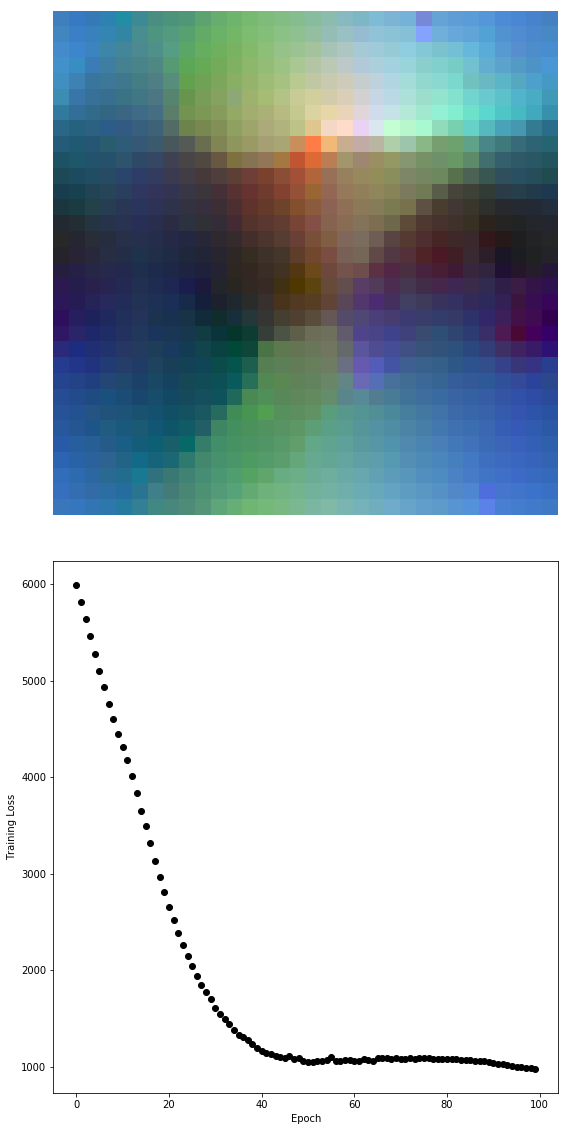

In [73]:
# resolution = 32
start = time.time()
galaxy_som32 = galaxy_demo(colors, nmap=-32)
print(time.time() - start)

Too much variation per cell...try increasing resolution to 50:

(3, 2500)
228.89204001426697


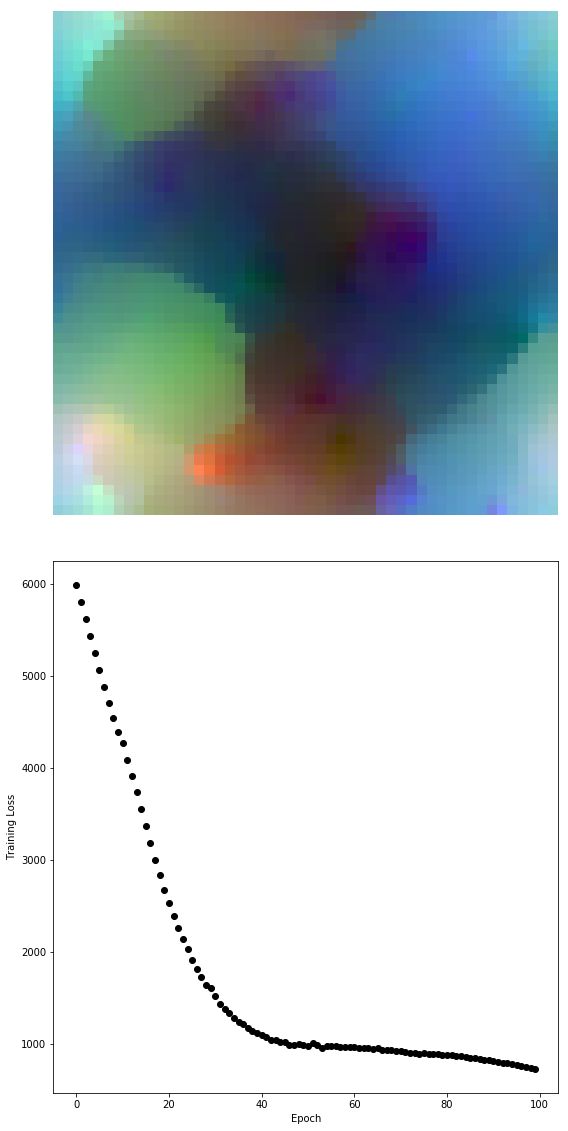

In [122]:
# resolution = 50
res = -50
start = time.time()
galaxy_som50 = galaxy_demo(colors, nmap=res)
print(time.time() - start)

436.99661898612976


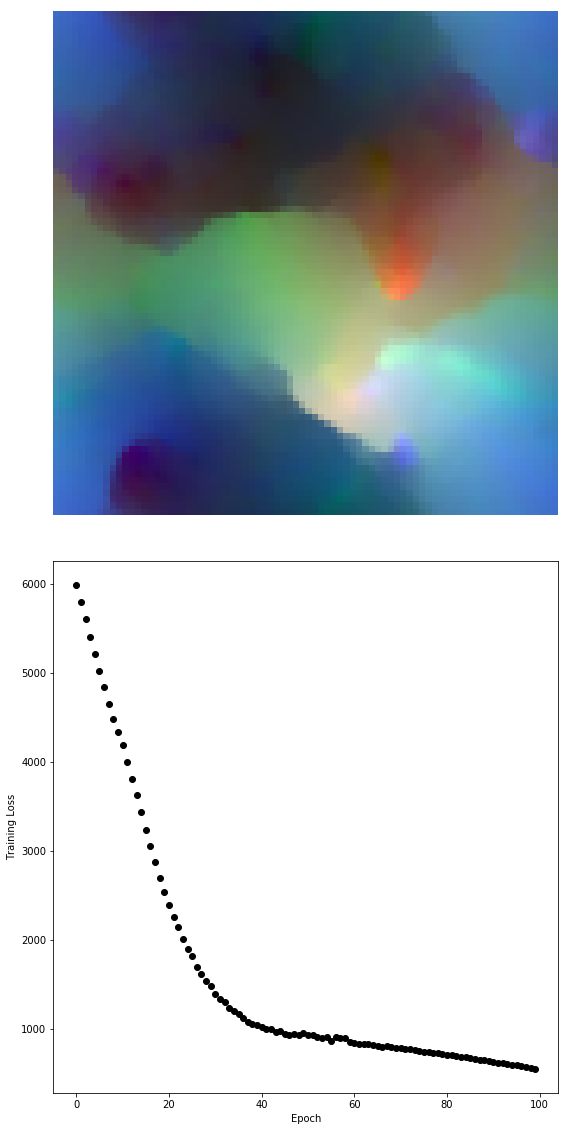

In [138]:
res = -80
start = time.time()
galaxy_som80 = galaxy_demo(colors, nmap=res)
print(time.time() - start)